# ML USE CASE 2 - Polish TRAIN COMPANY
### By Maud Tissot, Alexandre Smadja, Arthur Scelles, Aurélien Pouxviel
The dataset contains information about delays on polish railroads published by the Polish State Railways in real time. Data was scraped from https://infopasazer.intercity.pl. It covers the period from the midnight of 2022-05-16 until the midnight of 2022-05-30. Observations were collected every 5 minutes.

Columns:

- datetime - timestamp at which the sample was collected (Warsaw time)
- id - train ID
- carrier - the name of the carrier (mainly its PKP Intercity)
- date - date of the train departure
- connection - beginning and the destination for the train
- arrival - planned arrival time at the destination
- delay - current estimated delay
- name - train station name

## Our Task : 

Find the "domains" (train company, train station, connexion) for the ones our predicted delay from one day in advance isn"t that bad.

- 1St model to predict the delay from 1 day in advance (binary classification)
- Compute the delta between the prediction and real delay
- Then do a 2nd model to identify where the delta is acceptable. this can be done by clustering or decision tree.

## Summary

### 1. Import Libraries
### 2. Load dataset
### 3. Exploratory Analysis for our problematic
### 4. Preprocessing
### 5. 1st Prediction : delay from 24h in advance
### 6. 2nd Prediction : Decision Tree / clustering

### 1. Import Libraries

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joypy import joyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from scipy.cluster import hierarchy
import re
import math

### 2. Load dataset

In [2]:
df = pd.read_csv("delays.csv", encoding="ISO-8859-1")
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

,datetime,id,carrier,date,connection,arrival,delay,name
0,2022-05-16,41002/3 (102) POLONIA,PKP Intercity,2022-05-15,Bohumin - Warszawa Wschodnia,21:31,162 min,Warszawa Zachodnia
1,2022-05-16,91888/9 (102),Koleje Mazowieckie,2022-05-16,Siedlce - Warszawa Zachodnia,00:15,0 min,Warszawa Zachodnia
2,2022-05-16,21644/5 (102),Koleje Mazowieckie,2022-05-16,Radom GÅÃ³wny - Warszawa Wschodnia,00:29,0 min,Warszawa Zachodnia
3,2022-05-16,19300/1 (102),Koleje Mazowieckie,2022-05-16,Warszawa Wschodnia - Grodzisk Mazowiecki,00:34,0 min,Warszawa Zachodnia
4,2022-05-16,38170/1 (102) USTRONIE,PKP Intercity,2022-05-16,KrakÃ³w GÅÃ³wny - KoÅobrzeg,00:55,0 min,Warszawa Zachodnia


In [113]:
df = pd.read_csv("delays.csv", encoding="ISO-8859-1")
df.shape

(3718170, 8)

### 3. Exploratory Analysis for our problematic

    datetime                      id             carrier        date  \
0 2022-05-16   41002/3 (102) POLONIA       PKP Intercity  2022-05-15   
1 2022-05-16          91888/9 (102)   Koleje Mazowieckie  2022-05-16   
2 2022-05-16          21644/5 (102)   Koleje Mazowieckie  2022-05-16   
3 2022-05-16          19300/1 (102)   Koleje Mazowieckie  2022-05-16   
4 2022-05-16  38170/1 (102) USTRONIE       PKP Intercity  2022-05-16   

                                 connection arrival  delay                name  
0              Bohumin - Warszawa Wschodnia   21:31  162.0  Warszawa Zachodnia  
1              Siedlce - Warszawa Zachodnia   00:15    0.0  Warszawa Zachodnia  
2       Radom GÅÃ³wny - Warszawa Wschodnia   00:29    0.0  Warszawa Zachodnia  
3  Warszawa Wschodnia - Grodzisk Mazowiecki   00:34    0.0  Warszawa Zachodnia  
4             KrakÃ³w GÅÃ³wny - KoÅobrzeg   00:55    0.0  Warszawa Zachodnia  

Retard moyen par transporteur:
                              carrier     delay
0

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


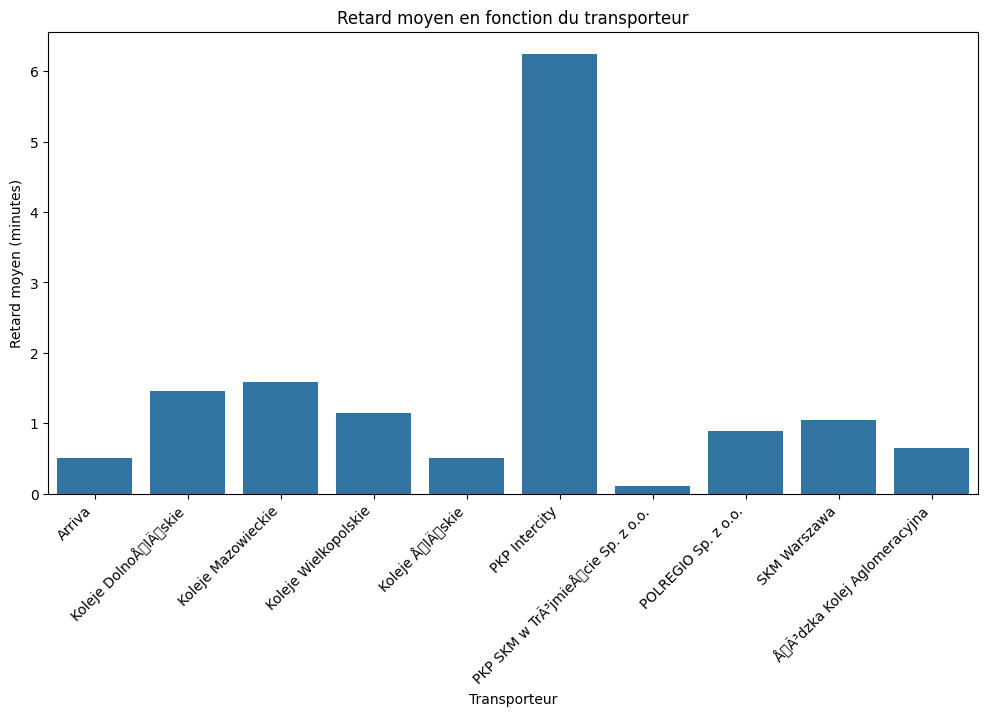

In [3]:
df['delay'] = df['delay'].str.extract('(\d+)').astype(float)
print(df.head())
average_delay_by_carrier = df.groupby('carrier')['delay'].mean().reset_index()

print("\nRetard moyen par transporteur:")
print(average_delay_by_carrier)

plt.figure(figsize=(12, 6))
sns.barplot(x='carrier', y='delay', data=average_delay_by_carrier)
plt.title('Retard moyen en fonction du transporteur')
plt.xlabel('Transporteur')
plt.ylabel('Retard moyen (minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


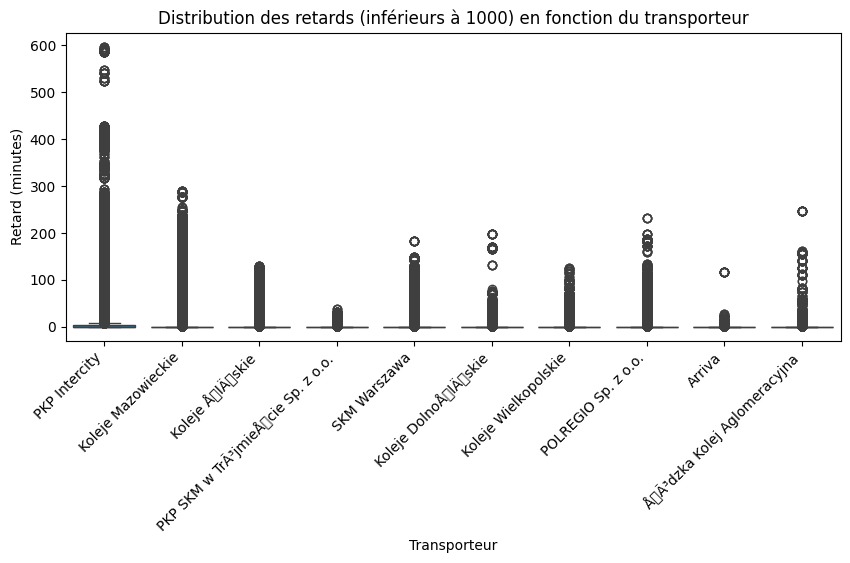

In [4]:
df_filtered = df[df['delay'] <= 1000]

plt.figure(figsize=(10, 4))
sns.boxplot(x='carrier', y='delay', data=df_filtered)
plt.title('Distribution des retards (inférieurs à 1000) en fonction du transporteur')
plt.xlabel('Transporteur')
plt.ylabel('Retard (minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [5]:
df = pd.read_csv("delays.csv", encoding="ISO-8859-1")
df['datetime'] = pd.to_datetime(df['datetime'])
df['delay'] = df['delay'].str.extract('(\d+)').astype(float)

train_id = '41002/3 (102) POLONIA'
df_train = df[df['id'] == train_id]
df_train.tail(5)

,datetime,id,carrier,date,connection,arrival,delay,name
3703702,2022-05-29 21:45:00,41002/3 (102) POLONIA,PKP Intercity,2022-05-29,Bohumin - Warszawa Wschodnia,21:49,10.0,Warszawa Wschodnia
3703817,2022-05-29 21:45:00,41002/3 (102) POLONIA,PKP Intercity,2022-05-29,Bohumin - Warszawa Wschodnia,21:38,11.0,Warszawa Centralna
3704670,2022-05-29 21:50:00,41002/3 (102) POLONIA,PKP Intercity,2022-05-29,Bohumin - Warszawa Wschodnia,21:49,10.0,Warszawa Wschodnia
3705417,2022-05-29 21:55:00,41002/3 (102) POLONIA,PKP Intercity,2022-05-29,Bohumin - Warszawa Wschodnia,21:49,10.0,Warszawa Wschodnia
3706196,2022-05-29 22:00:00,41002/3 (102) POLONIA,PKP Intercity,2022-05-29,Bohumin - Warszawa Wschodnia,21:49,12.0,Warszawa Wschodnia


### Retard moyen par station


Retard moyen par station pour le train 41002/3 (102) POLONIA:
                 name      delay
0            Katowice   6.932806
1              Rybnik   4.594286
2  Warszawa Centralna  11.501085
3   Warszawa GdaÅska  66.000000
4  Warszawa Wschodnia  21.228916
5  Warszawa Zachodnia  18.297468
6           Zawiercie   5.276850


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 132 (\x84) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


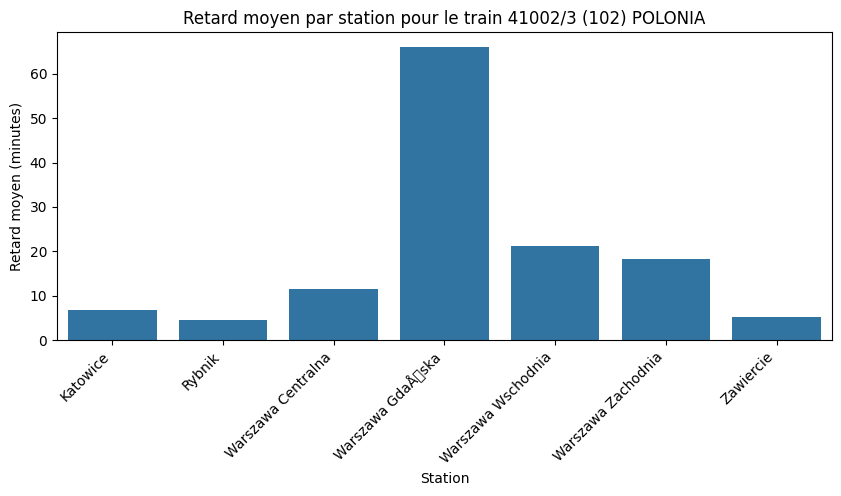

In [6]:
average_delay_by_station = df_train.groupby('name')['delay'].mean().reset_index()
print(f"\nRetard moyen par station pour le train {train_id}:")
print(average_delay_by_station)

plt.figure(figsize=(10, 4))
sns.barplot(x='name', y='delay', data=average_delay_by_station)
plt.title(f'Retard moyen par station pour le train {train_id}')
plt.xlabel('Station')
plt.ylabel('Retard moyen (minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()

# 4. PREPROCESSING

In [114]:
df = pd.read_csv("delays.csv", encoding="ISO-8859-1")
df.head()

,datetime,id,carrier,date,connection,arrival,delay,name
0,2022-05-16 00:00:00,41002/3 (102) POLONIA,PKP Intercity,2022-05-15,Bohumin - Warszawa Wschodnia,21:31,162 min,Warszawa Zachodnia
1,2022-05-16 00:00:00,91888/9 (102),Koleje Mazowieckie,2022-05-16,Siedlce - Warszawa Zachodnia,00:15,0 min,Warszawa Zachodnia
2,2022-05-16 00:00:00,21644/5 (102),Koleje Mazowieckie,2022-05-16,Radom GÅÃ³wny - Warszawa Wschodnia,00:29,0 min,Warszawa Zachodnia
3,2022-05-16 00:00:00,19300/1 (102),Koleje Mazowieckie,2022-05-16,Warszawa Wschodnia - Grodzisk Mazowiecki,00:34,0 min,Warszawa Zachodnia
4,2022-05-16 00:00:00,38170/1 (102) USTRONIE,PKP Intercity,2022-05-16,KrakÃ³w GÅÃ³wny - KoÅobrzeg,00:55,0 min,Warszawa Zachodnia


### On Filtre pour ne garder que la dernière info récupérée par trajet

In [115]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['id'] = df['id'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x).strip())
df_filtered = df.groupby(['id', 'carrier', 'date', 'connection', 'arrival', 'name'])['datetime'].idxmax()
df_filtered = df.loc[df_filtered]
df_filtered.to_csv("delays_filtred.csv", index=False)
df_filtered

,datetime,id,carrier,date,connection,arrival,delay,name
245982,2022-05-16 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:18,8 min,Warszawa Centralna
246806,2022-05-16 20:30:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:30,7 min,Warszawa Wschodnia
517894,2022-05-17 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna
519863,2022-05-17 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:30,0 min,Warszawa Wschodnia
793744,2022-05-18 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-18,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna
...,...,...,...,...,...,...,...,...
2689063,2022-05-25 23:50:00,99992/3,SKM Warszawa,2022-05-25,SulejÃ³wek MiÅosna - Warszawa Wschodnia,23:50,0 min,Warszawa Wschodnia
2963919,2022-05-26 23:40:00,99992/3,SKM Warszawa,2022-05-26,SulejÃ³wek MiÅosna - Warszawa Wschodnia,23:42,0 min,Warszawa RembertÃ³w
2964399,2022-05-26 23:50:00,99992/3,SKM Warszawa,2022-05-26,SulejÃ³wek MiÅosna - Warszawa Wschodnia,23:50,0 min,Warszawa Wschodnia
3242472,2022-05-27 23:40:00,99992/3,SKM Warszawa,2022-05-27,SulejÃ³wek MiÅosna - Warszawa Wschodnia,23:42,0 min,Warszawa RembertÃ³w


In [116]:
df.head(1)

,datetime,id,carrier,date,connection,arrival,delay,name
0,2022-05-16,41002/3 POLONIA,PKP Intercity,2022-05-15,Bohumin - Warszawa Wschodnia,21:31,162 min,Warszawa Zachodnia


### On test si tout est bien filtré

In [117]:
reference_row = df[(df['carrier'] == 'PKP Intercity') &
                   (df['date'] == '2022-05-15') &
                   (df['connection'] == 'Bohumin - Warszawa Wschodnia') &
                   (df['arrival'] == '21:31') &
                   (df['name'] == 'Warszawa Zachodnia')].iloc[0]
reference_row

datetime               2022-05-16 00:00:00
id                         41002/3 POLONIA
carrier                      PKP Intercity
date                            2022-05-15
connection    Bohumin - Warszawa Wschodnia
arrival                              21:31
delay                              162 min
name                    Warszawa Zachodnia
Name: 0, dtype: object

In [118]:
reference_row = df[(df['id'] == '41002/3 POLONIA') &
                   (df['carrier'] == 'PKP Intercity') &
                   (df['date'] == '2022-05-15') &
                   (df['connection'] == 'Bohumin - Warszawa Wschodnia') &
                   (df['arrival'] == '21:31') &
                   (df['name'] == 'Warszawa Zachodnia')].iloc[0]

similar_rows_initial = df[(df['id'] == reference_row['id']) &
                          (df['carrier'] == reference_row['carrier']) &
                          (df['date'] == reference_row['date']) &
                          (df['connection'] == reference_row['connection']) &
                          (df['arrival'] == reference_row['arrival']) &
                          (df['name'] == reference_row['name'])]

print("Lignes similaires dans le dataframe initial:")
print(similar_rows_initial)

reference_row_filtered = df_filtered[(df_filtered['id'] == '41002/3 POLONIA') &
                                      (df_filtered['carrier'] == 'PKP Intercity') &
                                      (df_filtered['date'] == '2022-05-15') &
                                      (df_filtered['connection'] == 'Bohumin - Warszawa Wschodnia') &
                                      (df_filtered['arrival'] == '21:31') &
                                      (df_filtered['name'] == 'Warszawa Zachodnia')].iloc[0]

similar_rows_filtered = df_filtered[(df_filtered['id'] == reference_row_filtered['id']) &
                                     (df_filtered['carrier'] == reference_row_filtered['carrier']) &
                                     (df_filtered['date'] == reference_row_filtered['date']) &
                                     (df_filtered['connection'] == reference_row_filtered['connection']) &
                                     (df_filtered['arrival'] == reference_row_filtered['arrival']) &
                                     (df_filtered['name'] == reference_row_filtered['name'])]

print("\nLignes similaires dans le DataFrame filtré:")
print(similar_rows_filtered)


Lignes similaires dans le dataframe initial:
               datetime               id        carrier        date  \
0   2022-05-16 00:00:00  41002/3 POLONIA  PKP Intercity  2022-05-15   
253 2022-05-16 00:05:00  41002/3 POLONIA  PKP Intercity  2022-05-15   
482 2022-05-16 00:10:00  41002/3 POLONIA  PKP Intercity  2022-05-15   
688 2022-05-16 00:15:00  41002/3 POLONIA  PKP Intercity  2022-05-15   
902 2022-05-16 00:20:00  41002/3 POLONIA  PKP Intercity  2022-05-15   

                       connection arrival    delay                name  
0    Bohumin - Warszawa Wschodnia   21:31  162 min  Warszawa Zachodnia  
253  Bohumin - Warszawa Wschodnia   21:31  162 min  Warszawa Zachodnia  
482  Bohumin - Warszawa Wschodnia   21:31  162 min  Warszawa Zachodnia  
688  Bohumin - Warszawa Wschodnia   21:31  170 min  Warszawa Zachodnia  
902  Bohumin - Warszawa Wschodnia   21:31  170 min  Warszawa Zachodnia  

Lignes similaires dans le DataFrame filtré:
               datetime               id     

In [119]:
df_filtered.head(3)

,datetime,id,carrier,date,connection,arrival,delay,name
245982,2022-05-16 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:18,8 min,Warszawa Centralna
246806,2022-05-16 20:30:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:30,7 min,Warszawa Wschodnia
517894,2022-05-17 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna


## Création de colonnes

### On rajoute la colonne que l'on va predire si Oui/non on a un retard (10 min max )

In [120]:
df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])
df_filtered['retard(Oui/Non)'] = np.where(df_filtered['delay'].str.extract('(\d+)').astype(float) > 10, 1, 0)
df_filtered.head(3)

,datetime,id,carrier,date,connection,arrival,delay,name,retard(Oui/Non)
245982,2022-05-16 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:18,8 min,Warszawa Centralna,0
246806,2022-05-16 20:30:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:30,7 min,Warszawa Wschodnia,0
517894,2022-05-17 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna,0


In [121]:
df_filtered['retard(Oui/Non)'].value_counts()

retard(Oui/Non)
0    228855
1     13061
Name: count, dtype: int64

### On rajoute une colonne avec le depart et le terminus

In [14]:
df_filtered[['gare de départ', 'terminus']] = df_filtered['connection'].str.split(' - ', expand=True)
df_filtered = df_filtered.rename(columns={'name': 'gare actuelle'})
df_filtered.head()

,datetime,id,carrier,date,connection,arrival,delay,gare actuelle,retard(Oui/Non),gare de départ,terminus
245982,2022-05-16 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:18,8 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok
246806,2022-05-16 20:30:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:30,7 min,Warszawa Wschodnia,0,Warszawa Zachodnia,BiaÅystok
517894,2022-05-17 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok
519863,2022-05-17 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:30,0 min,Warszawa Wschodnia,0,Warszawa Zachodnia,BiaÅystok
793744,2022-05-18 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-18,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok


### On rajoute le jour de la semaine

In [15]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered['jour de la semaine'] = df_filtered['date'].dt.dayofweek + 1
df_filtered.head()

,datetime,id,carrier,date,connection,arrival,delay,gare actuelle,retard(Oui/Non),gare de départ,terminus,jour de la semaine
245982,2022-05-16 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:18,8 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok,1
246806,2022-05-16 20:30:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:30,7 min,Warszawa Wschodnia,0,Warszawa Zachodnia,BiaÅystok,1
517894,2022-05-17 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok,2
519863,2022-05-17 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:30,0 min,Warszawa Wschodnia,0,Warszawa Zachodnia,BiaÅystok,2
793744,2022-05-18 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-18,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok,3


### Le week end

In [16]:
df_filtered['week-end'] = df_filtered['date'].dt.weekday.isin([6, 7]).astype(int)
df_filtered.head()

,datetime,id,carrier,date,connection,arrival,delay,gare actuelle,retard(Oui/Non),gare de départ,terminus,jour de la semaine,week-end
245982,2022-05-16 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:18,8 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok,1,0
246806,2022-05-16 20:30:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:30,7 min,Warszawa Wschodnia,0,Warszawa Zachodnia,BiaÅystok,1,0
517894,2022-05-17 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok,2,0
519863,2022-05-17 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:30,0 min,Warszawa Wschodnia,0,Warszawa Zachodnia,BiaÅystok,2,0
793744,2022-05-18 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-18,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok,3,0


### différent tests et analyses des colonnes a numériser

In [17]:
nb_valeurs_gare_actuelle = df_filtered['gare actuelle'].nunique()
nb_valeurs_gare_depart = df_filtered['gare de départ'].nunique()
nb_valeurs_terminus = df_filtered['terminus'].nunique()

print("Nombre de valeurs uniques dans 'gare actuelle':", nb_valeurs_gare_actuelle)
print("Nombre de valeurs uniques dans 'gare de départ':", nb_valeurs_gare_depart)
print("Nombre de valeurs uniques dans 'terminus':", nb_valeurs_terminus)

Nombre de valeurs uniques dans 'gare actuelle': 95
Nombre de valeurs uniques dans 'gare de départ': 284
Nombre de valeurs uniques dans 'terminus': 200


In [18]:
value_counts_gare_actuelle = df_filtered['gare actuelle'].value_counts()
value_counts_gare_depart = df_filtered['gare de départ'].value_counts()
value_counts_terminus = df_filtered['terminus'].value_counts()

print("Décompte des occurrences dans 'gare actuelle':")
print(value_counts_gare_actuelle)

print("\nDécompte des occurrences dans 'gare de départ':")
print(value_counts_gare_depart)

print("\nDécompte des occurrences dans 'terminus':")
print(value_counts_terminus)

Décompte des occurrences dans 'gare actuelle':
gare actuelle
Warszawa Zachodnia         9588
Warszawa Wschodnia         9242
Warszawa ÅrÃ³dmieÅcie    7011
Warszawa Stadion           6764
Warszawa PowiÅle          6762
                           ... 
Jasionna Åowicka           295
KÄszyce                    295
Nowa Sucha                  295
Bednary                     289
MysÅakÃ³w                  284
Name: count, Length: 95, dtype: int64

Décompte des occurrences dans 'gare de départ':
gare de départ
GdaÅsk ÅrÃ³dmieÅcie    23162
Warszawa Wschodnia        15397
Gdynia GÅÃ³wna           14482
Wejherowo                 13466
Otwock                    13346
                          ...  
MaÅdyty                      1
StarczÃ³w                     1
Kamieniec ZÄbkowicki         1
Opole Wschodnie               1
RaszÃ³wka                     1
Name: count, Length: 284, dtype: int64

Décompte des occurrences dans 'terminus':
terminus
GdaÅsk ÅrÃ³dmieÅcie    22100
Warszawa W

In [19]:
np.unique(df_filtered["terminus"])

array(['Bednary', 'BiaÅ\x82ystok', 'Bielsko-BiaÅ\x82a GÅ\x82Ã³wna',
       'BierutÃ³w', 'Bohumin', 'Bohumin Vrbice', 'Busko-ZdrÃ³j',
       'Bydgoszcz GÅ\x82Ã³wna', 'Bydgoszcz WschÃ³d',
       'Bystrzyca KÅ\x82odzka PrzedmieÅ\x9bcie', 'BÅ\x82onie',
       'CelestynÃ³w', 'ChaÅ\x82upki', 'CheÅ\x82m', 'Chojnice',
       'Choszczno', 'CiechanÃ³w', 'Cieszyn', 'CzachÃ³wek PoÅ\x82udniowy',
       'CzempiÅ\x84', 'Czeremcha', 'CzÄ\x99stochowa', 'Drzewica',
       'DziaÅ\x82dowo', 'DÄ\x85browa GÃ³rnicza ZÄ\x85bkowice',
       'DÄ\x99bica', 'DÄ\x99blin', 'ElblÄ\x85g', 'EÅ\x82k',
       'Frankfurt/Oder', 'GdaÅ\x84sk GÅ\x82Ã³wny', 'GdaÅ\x84sk Wrzeszcz',
       'GdaÅ\x84sk Å\x9arÃ³dmieÅ\x9bcie', 'Gdynia Chylonia',
       'Gdynia Cisowa', 'Gdynia GÅ\x82Ã³wna',
       'Gdynia Stocznia-Uniwersytet Morski', 'GiÅ¼ycko', 'Gliwice',
       'Gniezno', 'GoleniÃ³w', 'GorzÃ³w Wielkopolski', 'GoÅ\x82aÅ\x84cz',
       'Grodzisk Mazowiecki', 'Grodzisk Wielkopolski', 'GÃ³ra Kalwaria',
       'GÅ\x82ogÃ³w', 'Hel', 

In [20]:
np.unique(df_filtered["gare actuelle"])

array(['Bednary', 'Bochnia', 'Bydgoszcz GÅ\x82Ã³wna', 'CzÄ\x99stochowa',
       'GdaÅ\x84sk GÅ\x82Ã³wny', 'GdaÅ\x84sk Oliwa',
       'GdaÅ\x84sk Politechnika', 'GdaÅ\x84sk Przymorze-Uniwersytet',
       'GdaÅ\x84sk Stocznia', 'GdaÅ\x84sk Wrzeszcz', 'GdaÅ\x84sk Zaspa',
       'GdaÅ\x84sk Å»abianka-AWFiS', 'Gdynia Chylonia', 'Gdynia Cisowa',
       'Gdynia GÅ\x82Ã³wna', 'Gdynia Leszczynki', 'Gdynia RedÅ\x82owo',
       'Gdynia Stocznia-Uniwersytet Morski',
       'Gdynia WzgÃ³rze Å\x9aw.Maksymiliana', 'Gliwice',
       'Grodzisk Mazowiecki', 'Jasionna Å\x81owicka', 'JÃ³zefÃ³w',
       'Katowice', 'Katowice BrynÃ³w', 'Katowice Ligota',
       'Katowice Piotrowice', 'Katowice Szopienice PoÅ\x82udniowe',
       'Katowice Zawodzie', 'Koluszki', 'Konin', 'Kornelin',
       'KrakÃ³w GÅ\x82Ã³wny', 'Kutno', 'KÄ\x99szyce', 'Legionowo',
       'Michalin', 'MysÅ\x82akÃ³w', 'MysÅ\x82owice', 'Nowa Sucha',
       'Nowy DwÃ³r Mazowiecki', 'Otwock', 'PiastÃ³w',
       'PoznaÅ\x84 GÅ\x82Ã³wny', 'PruszkÃ³

### On enregistre

In [21]:
df_filtered.to_csv("delays_filtred.csv", index=False)
df_filtered

,datetime,id,carrier,date,connection,arrival,delay,gare actuelle,retard(Oui/Non),gare de départ,terminus,jour de la semaine,week-end
245982,2022-05-16 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:18,8 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok,1,0
246806,2022-05-16 20:30:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - BiaÅystok,20:30,7 min,Warszawa Wschodnia,0,Warszawa Zachodnia,BiaÅystok,1,0
517894,2022-05-17 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok,2,0
519863,2022-05-17 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - BiaÅystok,20:30,0 min,Warszawa Wschodnia,0,Warszawa Zachodnia,BiaÅystok,2,0
793744,2022-05-18 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-18,Warszawa Zachodnia - BiaÅystok,20:18,0 min,Warszawa Centralna,0,Warszawa Zachodnia,BiaÅystok,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689063,2022-05-25 23:50:00,99992/3,SKM Warszawa,2022-05-25,SulejÃ³wek MiÅosna - Warszawa Wschodnia,23:50,0 min,Warszawa Wschodnia,0,SulejÃ³wek MiÅosna,Warszawa Wschodnia,3,0
2963919,2022-05-26 23:40:00,99992/3,SKM Warszawa,2022-05-26,SulejÃ³wek MiÅosna - Warszawa Wschodnia,23:42,0 min,Warszawa RembertÃ³w,0,SulejÃ³wek MiÅosna,Warszawa Wschodnia,4,0
2964399,2022-05-26 23:50:00,99992/3,SKM Warszawa,2022-05-26,SulejÃ³wek MiÅosna - Warszawa Wschodnia,23:50,0 min,Warszawa Wschodnia,0,SulejÃ³wek MiÅosna,Warszawa Wschodnia,4,0
3242472,2022-05-27 23:40:00,99992/3,SKM Warszawa,2022-05-27,SulejÃ³wek MiÅosna - Warszawa Wschodnia,23:42,0 min,Warszawa RembertÃ³w,0,SulejÃ³wek MiÅosna,Warszawa Wschodnia,5,0


### Creation d'un dico pour associer à chaque gare différente un numéro

In [22]:
gares_uniques = pd.unique(df_filtered[['gare actuelle', 'gare de départ', 'terminus']].values.ravel('K'))
gares_dict = {gare: idx + 1 for idx, gare in enumerate(gares_uniques)}
gares_dict

{'Warszawa Centralna': 1,
 'Warszawa Wschodnia': 2,
 'Warszawa Zachodnia': 3,
 'Å\x81Ã³dÅº Widzew': 4,
 'Koluszki': 5,
 'Skierniewice': 6,
 'Å»yrardÃ³w': 7,
 'Grodzisk Mazowiecki': 8,
 'Warszawa GdaÅ\x84ska': 9,
 'Kutno': 10,
 'Å\x81owicz GÅ\x82Ã³wny': 11,
 'Warszawa RembertÃ³w': 12,
 'Legionowo': 13,
 'Warszawa Stadion': 14,
 'Warszawa PowiÅ\x9ble': 15,
 'Warszawa Å\x9arÃ³dmieÅ\x9bcie': 16,
 'Warszawa Ochota': 17,
 'Warszawa WÅ\x82ochy': 18,
 'Warszawa Ursus': 19,
 'Warszawa Ursus NiedÅºwiadek': 20,
 'PiastÃ³w': 21,
 'PruszkÃ³w': 22,
 'Otwock': 23,
 'Warszawa SÅ\x82uÅ¼ewiec': 24,
 'Radom GÅ\x82Ã³wny': 25,
 'Warszawa Olszynka Grochowska': 26,
 'Warszawa GocÅ\x82awek': 27,
 'Warszawa Wawer': 28,
 'Warszawa Anin': 29,
 'Warszawa MiÄ\x99dzylesie': 30,
 'Warszawa RadoÅ\x9bÄ\x87': 31,
 'Warszawa Miedzeszyn': 32,
 'Warszawa Falenica': 33,
 'Michalin': 34,
 'JÃ³zefÃ³w': 35,
 'Å\x9awider': 36,
 'KrakÃ³w GÅ\x82Ã³wny': 37,
 'TarnÃ³w': 38,
 'RzeszÃ³w GÅ\x82Ã³wny': 39,
 'Bochnia': 40,
 'CzÄ\x99sto

In [23]:
connections = pd.unique(df_filtered[['connection']].values.ravel('K'))
connections_dict = {gare: idx + 1 for idx, gare in enumerate(connections)}
connections_dict

{'Warszawa Zachodnia - BiaÅ\x82ystok': 1,
 'BiaÅ\x82ystok - Warszawa Wschodnia': 2,
 'BiaÅ\x82ystok - Warszawa Zachodnia': 3,
 'Å\x81Ã³dÅº Fabryczna - Warszawa GÅ\x82Ã³wna': 4,
 'Å\x81Ã³dÅº Kaliska - Warszawa GÅ\x82Ã³wna': 5,
 'Å\x81Ã³dÅº Kaliska - Å»yrardÃ³w': 6,
 'Å\x81Ã³dÅº Kaliska - Warszawa GdaÅ\x84ska': 7,
 'Å\x81ukÃ³w - Warszawa Wschodnia': 8,
 'Å\x81ukÃ³w - Warszawa Zachodnia': 9,
 'Siedlce - Warszawa Centralna': 10,
 'Siedlce - Warszawa Wschodnia': 11,
 'Å\x81owicz GÅ\x82Ã³wny - Kutno': 12,
 'Skierniewice - Kutno': 13,
 'Skierniewice - Å\x81owicz GÅ\x82Ã³wny': 14,
 'Kutno - Skierniewice': 15,
 'Kutno - Å\x81owicz PrzedmieÅ\x9bcie': 16,
 'Kutno - Å\x81owicz GÅ\x82Ã³wny': 17,
 'Å\x81Ã³dÅº Fabryczna - TomaszÃ³w Mazowiecki': 18,
 'TomaszÃ³w Mazowiecki - Pabianice': 19,
 'TomaszÃ³w Mazowiecki - Å\x81Ã³dÅº Fabryczna': 20,
 'BiaÅ\x82ystok - Å\x81Ã³dÅº Fabryczna': 21,
 'BiaÅ\x82ystok - Å\x81Ã³dÅº Widzew': 22,
 'Terespol - Warszawa Wschodnia': 23,
 'Warszawa GÅ\x82Ã³wna - Å\x81Ã³dÅº Fa

### associer un numéro à chaque gare des 3 colonnes : gare actuelle gare de départ et terminus

In [24]:
df_filtered2 = df_filtered.copy()
df_filtered['gare actuelle'] = df_filtered['gare actuelle'].map(gares_dict)
df_filtered['gare de départ'] = df_filtered['gare de départ'].map(gares_dict)
df_filtered['terminus'] = df_filtered['terminus'].map(gares_dict)
df_filtered['connection'] = df_filtered['connection'].map(connections_dict)

nan_count_gare_actuelle = df_filtered['gare actuelle'].isna().sum()
nan_count_gare_depart = df_filtered['gare de départ'].isna().sum()
nan_count_terminus = df_filtered['terminus'].isna().sum()
nan_count_connection = df_filtered['connection'].isna().sum()

print("Nombre de NaN dans 'gare actuelle':", nan_count_gare_actuelle)
print("Nombre de NaN dans 'gare de départ':", nan_count_gare_depart)
print("Nombre de NaN dans 'terminus':", nan_count_terminus)
print("Nombre de NaN dans 'connectiob':", nan_count_connection)

Nombre de NaN dans 'gare actuelle': 0
Nombre de NaN dans 'gare de départ': 0
Nombre de NaN dans 'terminus': 0
Nombre de NaN dans 'connectiob': 0


### conversion des heures d'arrivées en minute et date en int

In [25]:
df_filtered = df_filtered[df_filtered['arrival'] != "Nie dotyczy"]
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered['arrival'] = pd.to_datetime(df_filtered['arrival'], format='%H:%M')
df_filtered['date_integer'] = df_filtered['datetime'].dt.strftime('%Y%m%d').astype(int)

df_filtered['arrival_minutes'] = df_filtered['arrival'].dt.hour * 60 + df_filtered['arrival'].dt.minute

C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\1488263546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered['date'])
C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\1488263546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['arrival'] = pd.to_datetime(df_filtered['arrival'], format='%H:%M')
C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\1488263546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

### numerisation de id

In [26]:
df_filtered['id'] = pd.factorize(df_filtered['id'])[0] + 1
df_filtered.head(2)

C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\3985913289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['id'] = pd.factorize(df_filtered['id'])[0] + 1


,datetime,id,carrier,date,connection,arrival,delay,gare actuelle,retard(Oui/Non),gare de départ,terminus,jour de la semaine,week-end,date_integer,arrival_minutes
245982,2022-05-16 20:25:00,1,PKP Intercity,2022-05-16,1,1900-01-01 20:18:00,8 min,1,0,3,96,1,0,20220516,1218
246806,2022-05-16 20:30:00,1,PKP Intercity,2022-05-16,1,1900-01-01 20:30:00,7 min,2,0,3,96,1,0,20220516,1230


In [27]:
#df_filtered['connection'] = pd.factorize(df_filtered['connection'])[0] + 1

### séparation des carrier en 10 colonnes

In [28]:
df_filtered = pd.get_dummies(df_filtered, columns=['carrier'])

### enregistre le csv pret

In [29]:
df_filtered.to_csv("delays_preprocess.csv", index=False)
df_filtered.head()

,datetime,id,date,connection,arrival,delay,gare actuelle,retard(Oui/Non),gare de départ,terminus,...,carrier_Arriva,carrier_Koleje DolnoÅlÄ skie,carrier_Koleje Mazowieckie,carrier_Koleje Wielkopolskie,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna
245982,2022-05-16 20:25:00,1,2022-05-16,1,1900-01-01 20:18:00,8 min,1,0,3,96,...,False,False,False,False,False,True,False,False,False,False
246806,2022-05-16 20:30:00,1,2022-05-16,1,1900-01-01 20:30:00,7 min,2,0,3,96,...,False,False,False,False,False,True,False,False,False,False
517894,2022-05-17 20:15:00,1,2022-05-17,1,1900-01-01 20:18:00,0 min,1,0,3,96,...,False,False,False,False,False,True,False,False,False,False
519863,2022-05-17 20:25:00,1,2022-05-17,1,1900-01-01 20:30:00,0 min,2,0,3,96,...,False,False,False,False,False,True,False,False,False,False
793744,2022-05-18 20:15:00,1,2022-05-18,1,1900-01-01 20:18:00,0 min,1,0,3,96,...,False,False,False,False,False,True,False,False,False,False


# Machine Learning

### Split le dernier jour en test

In [30]:
np.random.seed(0)
features_to_include = ['id','date_integer','arrival_minutes','connection','gare actuelle','terminus','gare de départ','week-end','jour de la semaine',
                       'carrier_Arriva','carrier_Koleje DolnoÅlÄskie',
                       'carrier_Koleje Mazowieckie','carrier_Koleje Wielkopolskie',
                       'carrier_Koleje ÅlÄskie',
                       'carrier_PKP Intercity','carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.',
                       'carrier_POLREGIO Sp. z o.o.','carrier_SKM Warszawa','carrier_ÅÃ³dzka Kolej Aglomeracyjna']


train_data = df_filtered[df_filtered['date'] < '2022-05-28']
test_data = df_filtered[df_filtered['date'].dt.date == pd.to_datetime('2022-05-29').date()]

X_train = train_data[features_to_include]
y_train = train_data['retard(Oui/Non)']

X_test = test_data[features_to_include]
y_test = test_data['retard(Oui/Non)']

X_test

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,carrier_Koleje DolnoÅlÄ skie,carrier_Koleje Mazowieckie,carrier_Koleje Wielkopolskie,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna
3687962,1,20220529,1218,1,1,96,3,1,7,False,False,False,False,False,True,False,False,False,False
3689787,1,20220529,1230,1,2,96,3,1,7,False,False,False,False,False,True,False,False,False,False
3683006,2,20220529,1218,1,1,96,3,1,7,False,False,False,False,False,True,False,False,False,False
3685309,2,20220529,1230,1,2,96,3,1,7,False,False,False,False,False,True,False,False,False,False
3528977,3,20220529,457,2,2,2,96,1,7,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715532,4346,20220529,1400,993,24,333,334,1,7,False,False,False,False,False,False,False,False,True,False
3715131,4347,20220529,1398,994,12,3,334,1,7,False,False,False,False,False,False,False,False,True,False
3715849,4347,20220529,1406,994,2,3,334,1,7,False,False,False,False,False,False,False,False,True,False
3716170,4347,20220529,1414,994,1,3,334,1,7,False,False,False,False,False,False,False,False,True,False


### Ml et premier résultat

C:\Users\aurel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\1534613707.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, pd.DataFrame({
C:\Users\aurel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control thi

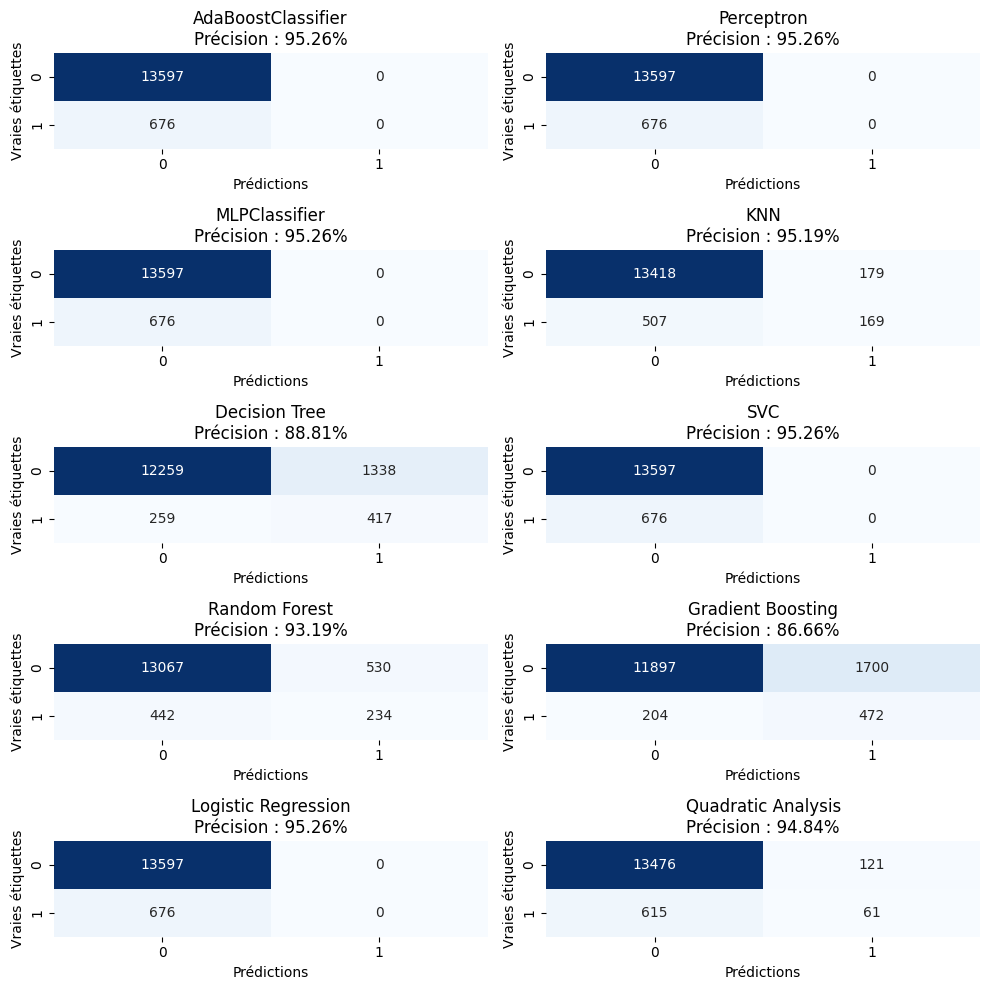

In [31]:
models = {
    'AdaBoostClassifier': AdaBoostClassifier(n_estimators=100, learning_rate=0.1),
    'Perceptron': Perceptron(),
    'MLPClassifier': MLPClassifier(),
    #'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVC': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Quadratic Analysis': QuadraticDiscriminantAnalysis()
}

model_results = pd.DataFrame(columns=['Model', 'FP', 'TP', 'FN', 'TN', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

num_models = len(models)
num_cols = 2
num_rows = math.ceil(num_models / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

axes = axes.flatten()

for i, (model_name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    row = i // num_cols
    col = i % num_cols

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    model_results = pd.concat([model_results, pd.DataFrame({
    'Model': [model_name],
    'FP': [fp],
    'TP': [tp],
    'FN': [fn],
    'TN': [tn],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1],
    'Accuracy': [accuracy]
})], ignore_index=True)

    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[i])
    axes[i].set_title(f'{model_name}\nPrécision : {accuracy * 100:.2f}%')
    axes[i].set_xlabel('Prédictions')
    axes[i].set_ylabel('Vraies étiquettes')

# Ajuster la mise en page
plt.tight_layout()
plt.show()

In [43]:
model_results_sorted = model_results.drop(model_results.loc[model_results["Model"] == "KNN"].index)

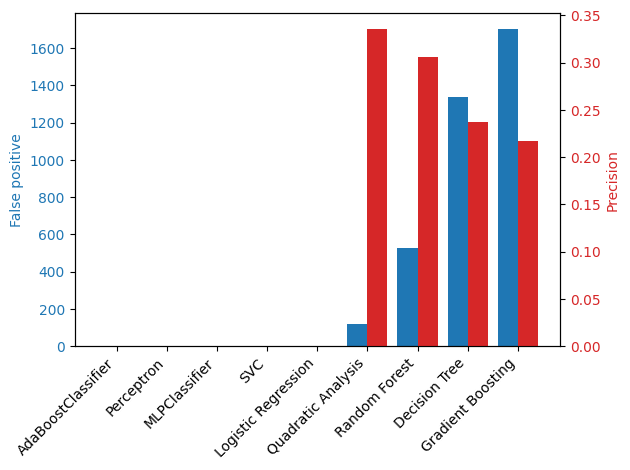

In [128]:
model_results_sorted = model_results.sort_values(by='FP')

model_results_sorted = model_results_sorted.reset_index(drop=True)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('False positive', color=color)
ax1.bar(model_results_sorted.index - 0.2, model_results_sorted['FP'], color=color, width=0.4)
ax1.tick_params(axis='y', labelcolor=color)

ax1.set_xticks(model_results_sorted.index)
ax1.set_xticklabels(model_results_sorted['Model'], rotation=45, ha='right')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Precision', color=color)
ax2.bar(model_results_sorted.index + 0.2, model_results_sorted['Precision'], color=color, width=0.4)
ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout()

plt.show()

## 1er model : entrainement jusqu'au 28, prédiction pour le 30

In [45]:
train_data = df_filtered[df_filtered['date'] < '2022-05-29']
test_data = df_filtered[df_filtered['date'].dt.date == pd.to_datetime('2022-05-30').date()]

X_train = train_data[features_to_include]
y_train = train_data['retard(Oui/Non)']

X_test = test_data[features_to_include]
y_test = test_data['retard(Oui/Non)']

X_test

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,carrier_Koleje DolnoÅlÄ skie,carrier_Koleje Mazowieckie,carrier_Koleje Wielkopolskie,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna
3718060,36,20220529,1,21,4,97,96,0,1,False,False,False,False,False,True,False,False,False,False
3718154,236,20220529,31,56,25,25,2,0,1,False,False,True,False,False,False,False,False,False,False
3718153,280,20220529,47,75,47,170,2,0,1,False,False,False,False,False,True,False,False,False,False
3718051,344,20220529,9,99,13,196,119,0,1,False,False,True,False,False,False,False,False,False,False
3718166,344,20220529,23,99,55,196,119,0,1,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3717898,4309,20220529,4,992,17,2,333,0,1,False,False,False,False,False,False,False,False,True,False
3718044,4309,20220529,7,992,16,2,333,0,1,False,False,False,False,False,False,False,False,True,False
3717939,4309,20220529,10,992,15,2,333,0,1,False,False,False,False,False,False,False,False,True,False
3717968,4309,20220529,13,992,14,2,333,0,1,False,False,False,False,False,False,False,False,True,False


Random Forest - Précision : 87.73%


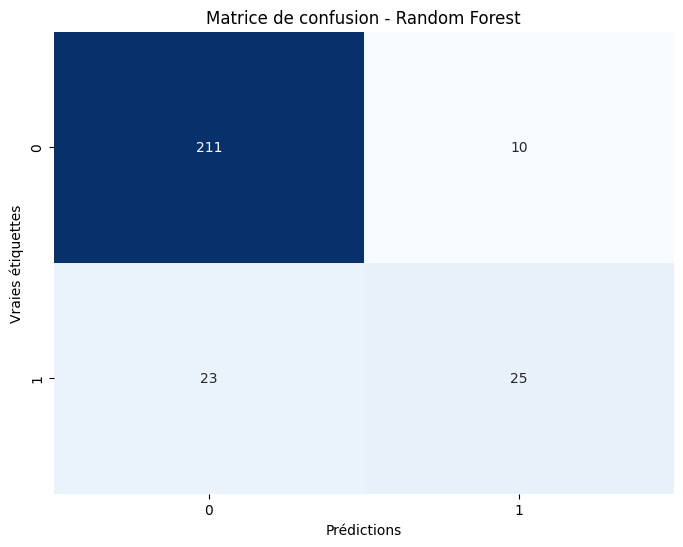

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


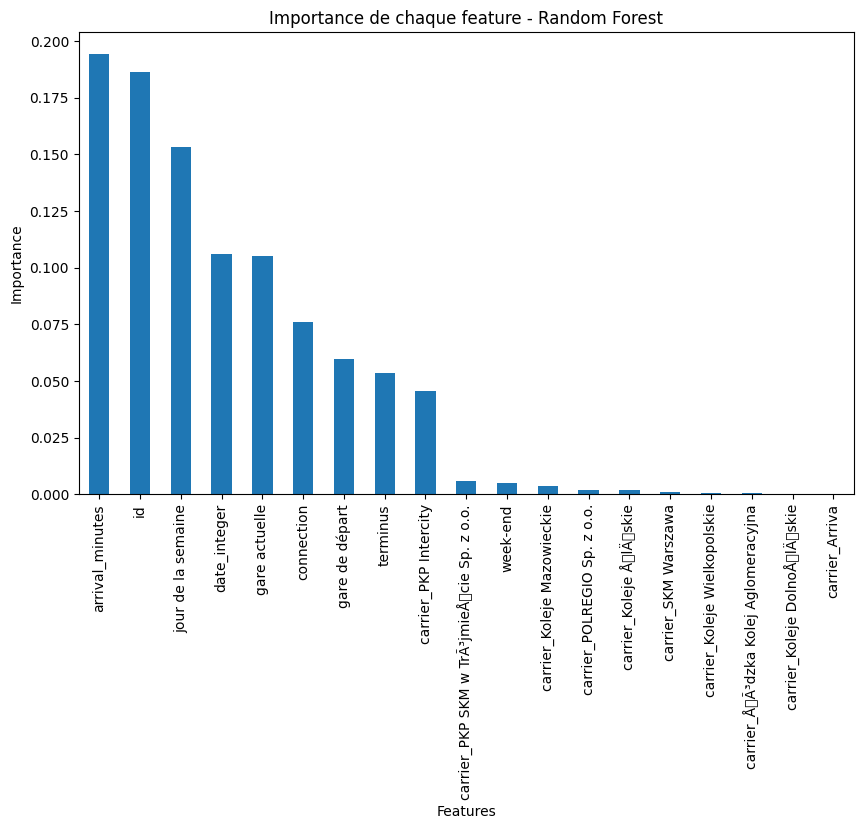

         y_true  y_pred  probability_retard  probability_ponctuelle
3718118       1       1                0.72                    0.28
3718108       1       1                0.71                    0.29
3718105       1       1                0.68                    0.32
3718102       1       1                0.69                    0.31
3718099       1       1                0.63                    0.37
3718107       1       1                0.57                    0.43
3717945       1       0                0.04                    0.96
3718080       1       0                0.05                    0.95
3718088       1       0                0.04                    0.96
3717911       1       0                0.02                    0.98
3718067       1       0                0.02                    0.98
3717904       1       0                0.03                    0.97
3717917       1       0                0.02                    0.98
3718040       1       0                0.03     

In [46]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

y_proba = rf_model.predict_proba(X_test)
# Ajouter une colonne avec la probabilité de la classe prédite
# Extraire les probabilités pour la classe positive (1) et la classe négative (0)
df_results = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability_retard': y_proba[:, 1],  # Probabilité pour la classe négative
    'probability_ponctuelle': y_proba[:, 0]   # Probabilité pour la classe positive
})

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest - Précision : {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Matrice de confusion - Random Forest')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Importance de chaque feature - Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

print(df_results[df_results['y_true'] == 1])

In [47]:
df_results.head(3)

,y_true,y_pred,probability_retard,probability_ponctuelle
3718060,0,0,0.04,0.96
3718154,0,0,0.09,0.91
3718153,0,1,0.65,0.35


In [48]:
df_final1 = pd.concat([X_test, df_results], axis=1)
df_final1.head(3)

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle
3718060,36,20220529,1,21,4,97,96,0,1,False,...,False,True,False,False,False,False,0,0,0.04,0.96
3718154,236,20220529,31,56,25,25,2,0,1,False,...,False,False,False,False,False,False,0,0,0.09,0.91
3718153,280,20220529,47,75,47,170,2,0,1,False,...,False,True,False,False,False,False,0,1,0.65,0.35


### Modele jusqu'au 27 inclus pour prédire le 29

In [49]:
train_data = df_filtered[df_filtered['date'] < '2022-05-28']
test_data = df_filtered[df_filtered['date'].dt.date == pd.to_datetime('2022-05-29').date()]

X_train = train_data[features_to_include]
y_train = train_data['retard(Oui/Non)']

X_test = test_data[features_to_include]
y_test = test_data['retard(Oui/Non)']

X_test

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,carrier_Koleje DolnoÅlÄ skie,carrier_Koleje Mazowieckie,carrier_Koleje Wielkopolskie,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna
3687962,1,20220529,1218,1,1,96,3,1,7,False,False,False,False,False,True,False,False,False,False
3689787,1,20220529,1230,1,2,96,3,1,7,False,False,False,False,False,True,False,False,False,False
3683006,2,20220529,1218,1,1,96,3,1,7,False,False,False,False,False,True,False,False,False,False
3685309,2,20220529,1230,1,2,96,3,1,7,False,False,False,False,False,True,False,False,False,False
3528977,3,20220529,457,2,2,2,96,1,7,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715532,4346,20220529,1400,993,24,333,334,1,7,False,False,False,False,False,False,False,False,True,False
3715131,4347,20220529,1398,994,12,3,334,1,7,False,False,False,False,False,False,False,False,True,False
3715849,4347,20220529,1406,994,2,3,334,1,7,False,False,False,False,False,False,False,False,True,False
3716170,4347,20220529,1414,994,1,3,334,1,7,False,False,False,False,False,False,False,False,True,False


Random Forest - Précision : 93.04%


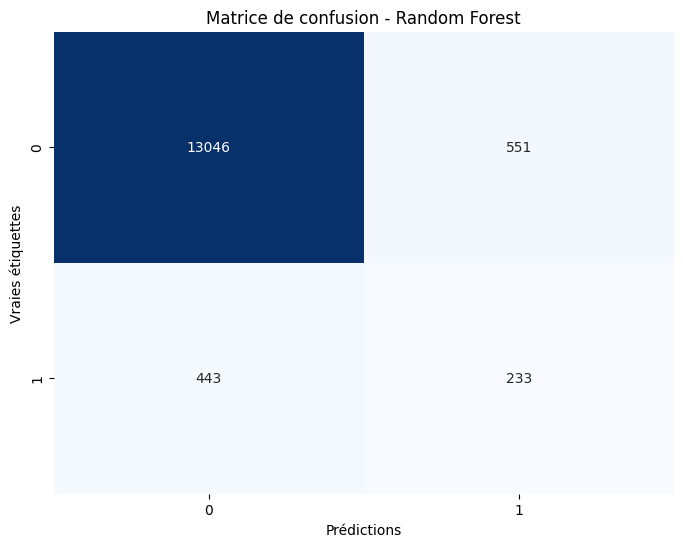

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


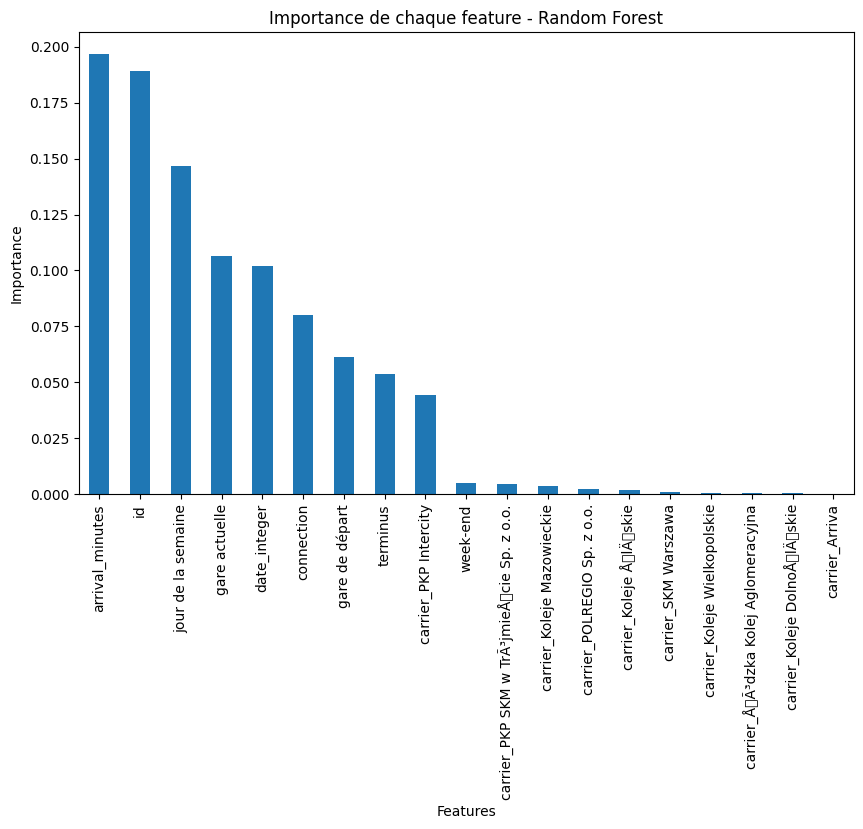

         y_true  y_pred  probability_retard  probability_ponctuelle
3717897       1       0                0.10                    0.90
3717879       1       0                0.10                    0.90
3718094       1       0                0.19                    0.81
3715121       1       0                0.16                    0.84
3715106       1       0                0.16                    0.84
...         ...     ...                 ...                     ...
3704235       1       0                0.02                    0.98
3704955       1       0                0.02                    0.98
3704950       1       0                0.02                    0.98
3705666       1       0                0.02                    0.98
3705697       1       0                0.02                    0.98

[676 rows x 4 columns]


In [50]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

y_proba = rf_model.predict_proba(X_test)
df_results2 = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability_retard': y_proba[:, 1],  # Probabilité pour la classe négative
    'probability_ponctuelle': y_proba[:, 0]   # Probabilité pour la classe positive
})

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest - Précision : {accuracy * 100:.2f}%")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Matrice de confusion - Random Forest')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Importance de chaque feature - Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

print(df_results2[df_results2['y_true'] == 1])


In [51]:
df_results2.head(3)

,y_true,y_pred,probability_retard,probability_ponctuelle
3687962,0,0,0.24,0.76
3689787,0,0,0.24,0.76
3683006,0,0,0.24,0.76


In [52]:
df_final2 = pd.concat([X_test, df_results2], axis=1)
df_final2.head(3)

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle
3687962,1,20220529,1218,1,1,96,3,1,7,False,...,False,True,False,False,False,False,0,0,0.24,0.76
3689787,1,20220529,1230,1,2,96,3,1,7,False,...,False,True,False,False,False,False,0,0,0.24,0.76
3683006,2,20220529,1218,1,1,96,3,1,7,False,...,False,True,False,False,False,False,0,0,0.24,0.76


### Modele jusq'au 26 inclus pour prédire le 28

In [53]:
train_data = df_filtered[df_filtered['date'] < '2022-05-27']
test_data = df_filtered[df_filtered['date'].dt.date == pd.to_datetime('2022-05-28').date()]

X_train = train_data[features_to_include]
y_train = train_data['retard(Oui/Non)']

X_test = test_data[features_to_include]
y_test = test_data['retard(Oui/Non)']

X_test

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,carrier_Koleje DolnoÅlÄ skie,carrier_Koleje Mazowieckie,carrier_Koleje Wielkopolskie,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna
3451740,1,20220528,1218,1,1,96,3,0,6,False,False,False,False,False,True,False,False,False,False
3453551,1,20220528,1230,1,2,96,3,0,6,False,False,False,False,False,True,False,False,False,False
3445147,2,20220528,1218,1,1,96,3,0,6,False,False,False,False,False,True,False,False,False,False
3449061,2,20220528,1230,1,2,96,3,0,6,False,False,False,False,False,True,False,False,False,False
3296802,3,20220528,457,2,2,2,96,0,6,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3477608,4346,20220528,1400,993,24,333,334,0,6,False,False,False,False,False,False,False,False,True,False
3477230,4347,20220528,1398,994,12,3,334,0,6,False,False,False,False,False,False,False,False,True,False
3477759,4347,20220528,1406,994,2,3,334,0,6,False,False,False,False,False,False,False,False,True,False
3478224,4347,20220528,1414,994,1,3,334,0,6,False,False,False,False,False,False,False,False,True,False


Random Forest - Précision : 90.37%


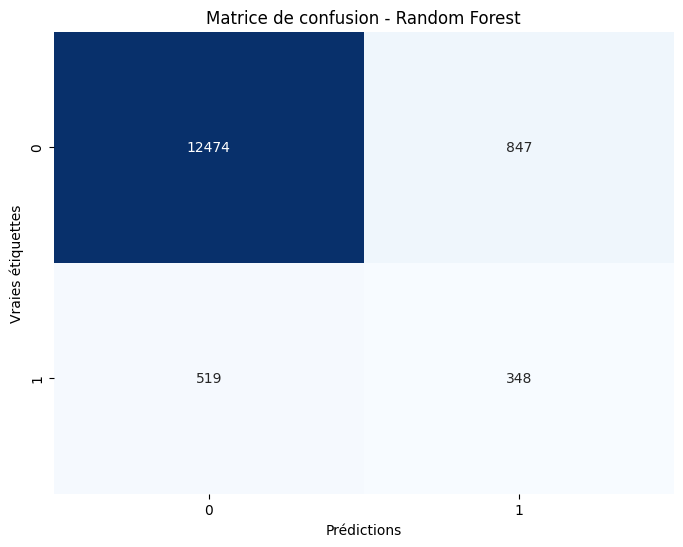

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


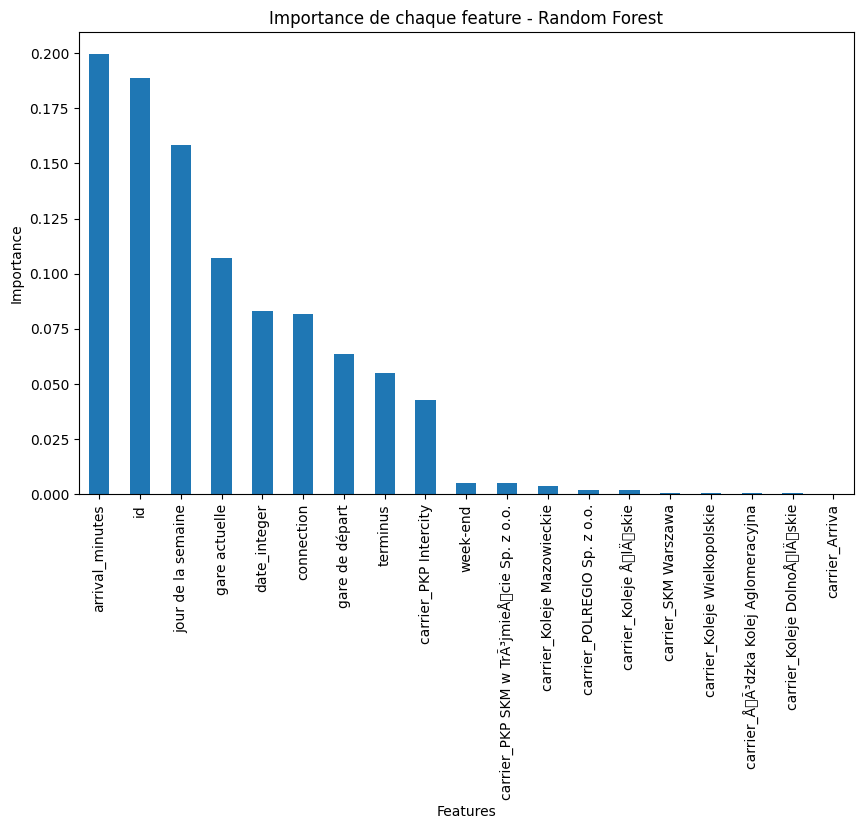

         y_true  y_pred  probability_retard  probability_ponctuelle
3305988       1       0                0.25                    0.75
3307999       1       0                0.26                    0.74
3309898       1       0                0.25                    0.75
3343252       1       0                0.16                    0.84
3466380       1       0                0.22                    0.78
...         ...     ...                 ...                     ...
3480387       1       0                0.09                    0.91
3480391       1       0                0.08                    0.92
3480972       1       0                0.12                    0.88
3300099       1       0                0.06                    0.94
3301848       1       0                0.06                    0.94

[867 rows x 4 columns]


In [54]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

y_proba = rf_model.predict_proba(X_test)
df_results3 = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability_retard': y_proba[:, 1],  # Probabilité pour la classe négative
    'probability_ponctuelle': y_proba[:, 0]   # Probabilité pour la classe positive
})

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest - Précision : {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Matrice de confusion - Random Forest')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Importance de chaque feature - Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

print(df_results3[df_results3['y_true'] == 1])

In [55]:
df_results3.head(3)

,y_true,y_pred,probability_retard,probability_ponctuelle
3451740,0,0,0.42,0.58
3453551,0,0,0.43,0.57
3445147,0,0,0.42,0.58


In [56]:
df_final3 = pd.concat([X_test, df_results3], axis=1)
df_final3.head(3)

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle
3451740,1,20220528,1218,1,1,96,3,0,6,False,...,False,True,False,False,False,False,0,0,0.42,0.58
3453551,1,20220528,1230,1,2,96,3,0,6,False,...,False,True,False,False,False,False,0,0,0.43,0.57
3445147,2,20220528,1218,1,1,96,3,0,6,False,...,False,True,False,False,False,False,0,0,0.42,0.58


### Modele jusqu'au 25 inclus pour prédire le 27

In [57]:
train_data = df_filtered[df_filtered['date'] < '2022-05-26']
test_data = df_filtered[df_filtered['date'].dt.date == pd.to_datetime('2022-05-27').date()]

X_train = train_data[features_to_include]
y_train = train_data['retard(Oui/Non)']

X_test = test_data[features_to_include]
y_test = test_data['retard(Oui/Non)']

X_test

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,carrier_Koleje DolnoÅlÄ skie,carrier_Koleje Mazowieckie,carrier_Koleje Wielkopolskie,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna
3210965,1,20220527,1218,1,1,96,3,0,5,False,False,False,False,False,True,False,False,False,False
3212905,1,20220527,1230,1,2,96,3,0,5,False,False,False,False,False,True,False,False,False,False
3205788,2,20220527,1218,1,1,96,3,0,5,False,False,False,False,False,True,False,False,False,False
3208082,2,20220527,1230,1,2,96,3,0,5,False,False,False,False,False,True,False,False,False,False
3027853,3,20220527,457,2,2,2,96,0,5,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3241074,4347,20220527,1406,994,2,3,334,0,5,False,False,False,False,False,False,False,False,True,False
3241386,4347,20220527,1414,994,1,3,334,0,5,False,False,False,False,False,False,False,False,True,False
3242133,4347,20220527,1422,994,3,3,334,0,5,False,False,False,False,False,False,False,False,True,False
3242472,4348,20220527,1422,995,12,2,334,0,5,False,False,False,False,False,False,False,False,True,False


Random Forest - Précision : 85.68%


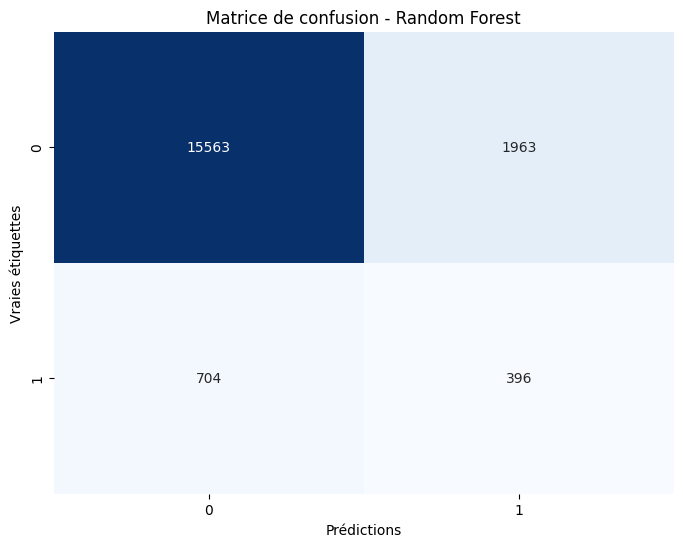

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


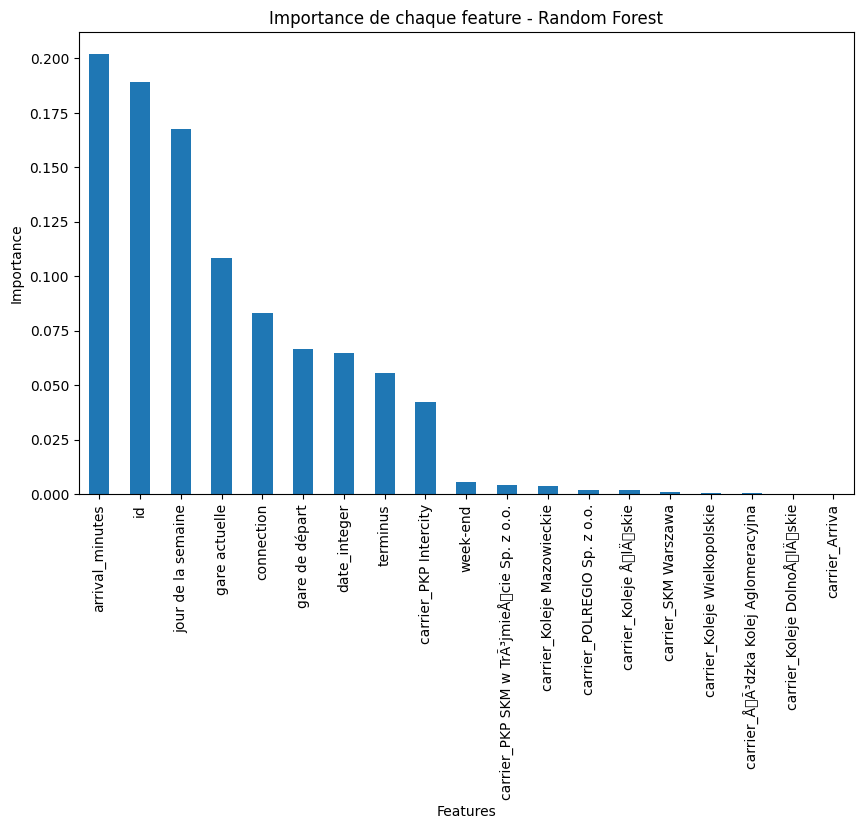

         y_true  y_pred  probability_retard  probability_ponctuelle
3223161       1       0                0.13                    0.87
3208218       1       0                0.11                    0.89
3223160       1       0                0.12                    0.88
3240654       1       0                0.12                    0.88
3242371       1       0                0.12                    0.88
...         ...     ...                 ...                     ...
3037862       1       0                0.00                    1.00
3037409       1       0                0.00                    1.00
3052271       1       0                0.01                    0.99
3062321       1       0                0.02                    0.98
3235064       1       0                0.03                    0.97

[1100 rows x 4 columns]


In [58]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)
df_results4 = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability_retard': y_proba[:, 1],  # Probabilité pour la classe négative
    'probability_ponctuelle': y_proba[:, 0]   # Probabilité pour la classe positive
})

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest - Précision : {accuracy * 100:.2f}%")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Matrice de confusion - Random Forest')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Importance de chaque feature - Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

print(df_results4[df_results4['y_true'] == 1])

In [59]:
df_results4.head(3)

,y_true,y_pred,probability_retard,probability_ponctuelle
3210965,0,0,0.49,0.51
3212905,0,0,0.48,0.52
3205788,0,1,0.51,0.49


In [60]:
df_final4 = pd.concat([X_test, df_results4], axis=1)
df_final4.head(3)

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle
3210965,1,20220527,1218,1,1,96,3,0,5,False,...,False,True,False,False,False,False,0,0,0.49,0.51
3212905,1,20220527,1230,1,2,96,3,0,5,False,...,False,True,False,False,False,False,0,0,0.48,0.52
3205788,2,20220527,1218,1,1,96,3,0,5,False,...,False,True,False,False,False,False,0,1,0.51,0.49


### Modele jusqu'au 24 inclus pour prédire le 26

In [61]:
train_data = df_filtered[df_filtered['date'] < '2022-05-25']
test_data = df_filtered[df_filtered['date'].dt.date == pd.to_datetime('2022-05-26').date()]

X_train = train_data[features_to_include]
y_train = train_data['retard(Oui/Non)']

X_test = test_data[features_to_include]
y_test = test_data['retard(Oui/Non)']

X_test

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,carrier_Koleje DolnoÅlÄ skie,carrier_Koleje Mazowieckie,carrier_Koleje Wielkopolskie,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna
2933478,1,20220526,1218,1,1,96,3,0,4,False,False,False,False,False,True,False,False,False,False
2935464,1,20220526,1230,1,2,96,3,0,4,False,False,False,False,False,True,False,False,False,False
2928391,2,20220526,1218,1,1,96,3,0,4,False,False,False,False,False,True,False,False,False,False
2930369,2,20220526,1230,1,2,96,3,0,4,False,False,False,False,False,True,False,False,False,False
2752705,3,20220526,457,2,2,2,96,0,4,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962580,4347,20220526,1406,994,2,3,334,0,4,False,False,False,False,False,False,False,False,True,False
2962926,4347,20220526,1414,994,1,3,334,0,4,False,False,False,False,False,False,False,False,True,False
2963601,4347,20220526,1422,994,3,3,334,0,4,False,False,False,False,False,False,False,False,True,False
2963919,4348,20220526,1422,995,12,2,334,0,4,False,False,False,False,False,False,False,False,True,False


Random Forest - Précision : 93.89%


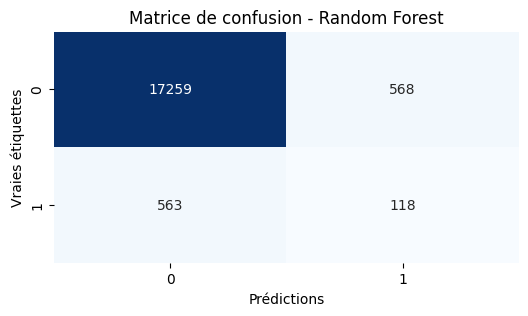

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


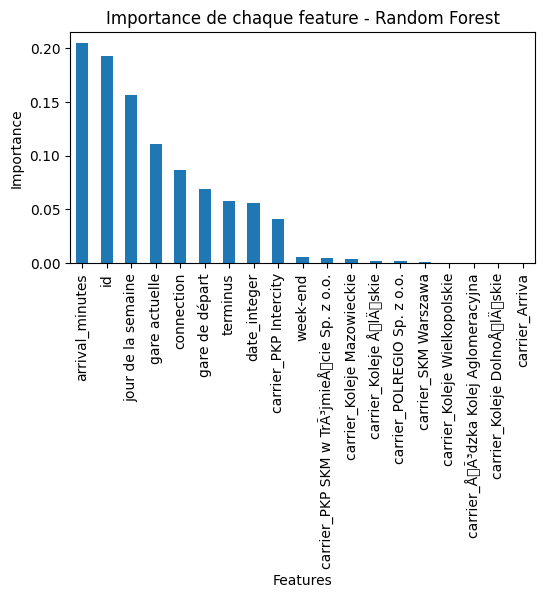

         y_true  y_pred  probability_retard  probability_ponctuelle
2817536       1       0                0.42                    0.58
2826305       1       0                0.00                    1.00
2830634       1       0                0.00                    1.00
2835391       1       0                0.01                    0.99
2955512       1       0                0.01                    0.99
...         ...     ...                 ...                     ...
2963504       1       0                0.02                    0.98
2963496       1       0                0.03                    0.97
2963850       1       0                0.03                    0.97
2963844       1       0                0.04                    0.96
2964211       1       0                0.04                    0.96

[681 rows x 4 columns]


In [62]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

y_proba = rf_model.predict_proba(X_test)
df_results5 = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability_retard': y_proba[:, 1],  # Probabilité pour la classe négative
    'probability_ponctuelle': y_proba[:, 0]   # Probabilité pour la classe positive
})

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest - Précision : {accuracy * 100:.2f}%")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Matrice de confusion - Random Forest')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(6, 3))
feature_importances.plot(kind='bar')
plt.title('Importance de chaque feature - Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

print(df_results5[df_results5['y_true'] == 1])

In [63]:
df_results5.head(3)

,y_true,y_pred,probability_retard,probability_ponctuelle
2933478,0,0,0.11,0.89
2935464,0,0,0.07,0.93
2928391,0,0,0.39,0.61


In [64]:
df_final5 = pd.concat([X_test, df_results5], axis=1)
df_final5.head(3)

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle
2933478,1,20220526,1218,1,1,96,3,0,4,False,...,False,True,False,False,False,False,0,0,0.11,0.89
2935464,1,20220526,1230,1,2,96,3,0,4,False,...,False,True,False,False,False,False,0,0,0.07,0.93
2928391,2,20220526,1218,1,1,96,3,0,4,False,...,False,True,False,False,False,False,0,0,0.39,0.61


## Modele jusqu'au 23 pour prédire le 25

In [65]:
train_data = df_filtered[df_filtered['date'] < '2022-05-24']
test_data = df_filtered[df_filtered['date'].dt.date == pd.to_datetime('2022-05-25').date()]

X_train = train_data[features_to_include]
y_train = train_data['retard(Oui/Non)']

X_test = test_data[features_to_include]
y_test = test_data['retard(Oui/Non)']

X_test

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,carrier_Koleje DolnoÅlÄ skie,carrier_Koleje Mazowieckie,carrier_Koleje Wielkopolskie,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna
2658180,1,20220525,1218,1,1,96,3,0,3,False,False,False,False,False,True,False,False,False,False
2660368,1,20220525,1230,1,2,96,3,0,3,False,False,False,False,False,True,False,False,False,False
2654127,2,20220525,1218,1,1,96,3,0,3,False,False,False,False,False,True,False,False,False,False
2655068,2,20220525,1230,1,2,96,3,0,3,False,False,False,False,False,True,False,False,False,False
2476977,3,20220525,457,2,2,2,96,0,3,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687210,4347,20220525,1406,994,2,3,334,0,3,False,False,False,False,False,False,False,False,True,False
2687715,4347,20220525,1414,994,1,3,334,0,3,False,False,False,False,False,False,False,False,True,False
2688363,4347,20220525,1422,994,3,3,334,0,3,False,False,False,False,False,False,False,False,True,False
2688674,4348,20220525,1422,995,12,2,334,0,3,False,False,False,False,False,False,False,False,True,False


Random Forest - Précision : 93.92%


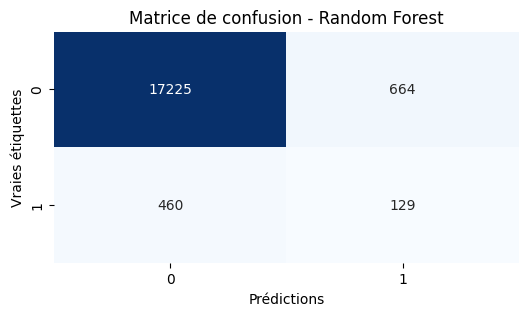

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


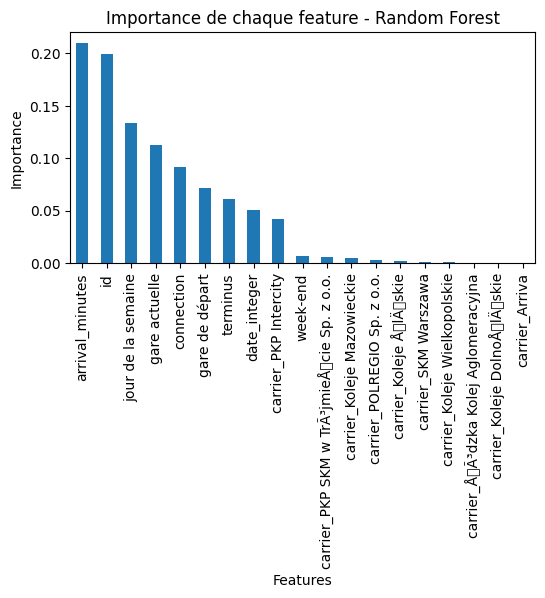

In [66]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

y_proba = rf_model.predict_proba(X_test)
df_results6 = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability_retard': y_proba[:, 1],  # Probabilité pour la classe négative
    'probability_ponctuelle': y_proba[:, 0]   # Probabilité pour la classe positive
})

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest - Précision : {accuracy * 100:.2f}%")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Matrice de confusion - Random Forest')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(6, 3))
feature_importances.plot(kind='bar')
plt.title('Importance de chaque feature - Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [67]:
df_final6 = pd.concat([X_test, df_results6], axis=1)
df_final6.head(3)

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle
2658180,1,20220525,1218,1,1,96,3,0,3,False,...,False,True,False,False,False,False,0,0,0.04,0.96
2660368,1,20220525,1230,1,2,96,3,0,3,False,...,False,True,False,False,False,False,0,0,0.02,0.98
2654127,2,20220525,1218,1,1,96,3,0,3,False,...,False,True,False,False,False,False,0,0,0.19,0.81


## Modele jusqu'au 22 pour prédire le 24

In [68]:
train_data = df_filtered[df_filtered['date'] < '2022-05-23']
test_data = df_filtered[df_filtered['date'].dt.date == pd.to_datetime('2022-05-24').date()]

X_train = train_data[features_to_include]
y_train = train_data['retard(Oui/Non)']

X_test = test_data[features_to_include]
y_test = test_data['retard(Oui/Non)']

X_test

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,carrier_Koleje DolnoÅlÄ skie,carrier_Koleje Mazowieckie,carrier_Koleje Wielkopolskie,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna
2382715,1,20220524,1218,1,1,96,3,0,2,False,False,False,False,False,True,False,False,False,False
2384863,1,20220524,1230,1,2,96,3,0,2,False,False,False,False,False,True,False,False,False,False
2377750,2,20220524,1218,1,1,96,3,0,2,False,False,False,False,False,True,False,False,False,False
2379676,2,20220524,1230,1,2,96,3,0,2,False,False,False,False,False,True,False,False,False,False
2202865,3,20220524,457,2,2,2,96,0,2,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411431,4347,20220524,1406,994,2,3,334,0,2,False,False,False,False,False,False,False,False,True,False
2411759,4347,20220524,1414,994,1,3,334,0,2,False,False,False,False,False,False,False,False,True,False
2412410,4347,20220524,1422,994,3,3,334,0,2,False,False,False,False,False,False,False,False,True,False
2412724,4348,20220524,1422,995,12,2,334,0,2,False,False,False,False,False,False,False,False,True,False


Random Forest - Précision : 94.22%


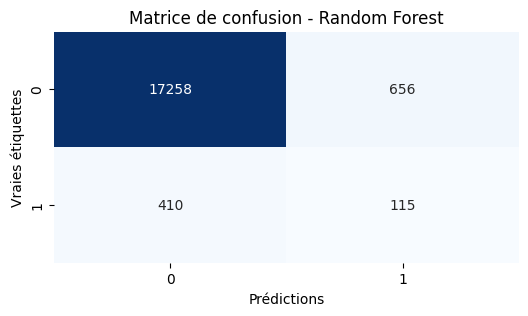

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


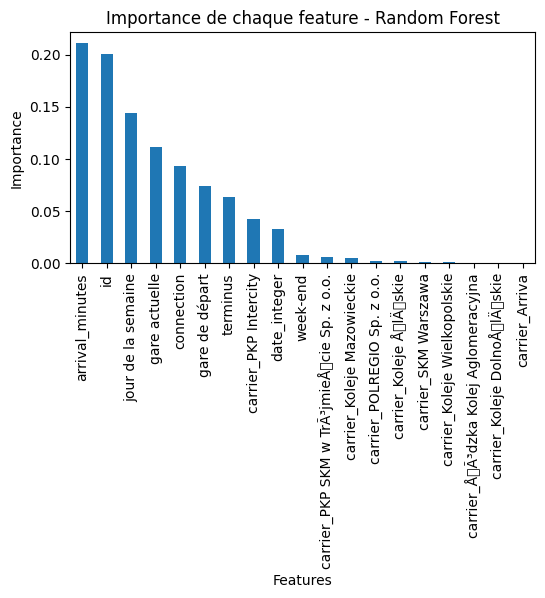

In [69]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

y_proba = rf_model.predict_proba(X_test)
df_results7 = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability_retard': y_proba[:, 1],  # Probabilité pour la classe négative
    'probability_ponctuelle': y_proba[:, 0]   # Probabilité pour la classe positive
})

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest - Précision : {accuracy * 100:.2f}%")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Matrice de confusion - Random Forest')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(6, 3))
feature_importances.plot(kind='bar')
plt.title('Importance de chaque feature - Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [70]:
df_final7 = pd.concat([X_test, df_results7], axis=1)
df_final7.head(3)

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle
2382715,1,20220524,1218,1,1,96,3,0,2,False,...,False,True,False,False,False,False,0,0,0.24,0.76
2384863,1,20220524,1230,1,2,96,3,0,2,False,...,False,True,False,False,False,False,0,0,0.19,0.81
2377750,2,20220524,1218,1,1,96,3,0,2,False,...,False,True,False,False,False,False,0,0,0.50,0.50


## CONCATENATION GLOBAL

In [71]:
df_combined = pd.concat([df_final1, df_final2,df_final3,df_final4,df_final5,df_final6,df_final7])
df_combined

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_Koleje ÅlÄ skie,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle
3718060,36,20220529,1,21,4,97,96,0,1,False,...,False,True,False,False,False,False,0,0,0.04,0.96
3718154,236,20220529,31,56,25,25,2,0,1,False,...,False,False,False,False,False,False,0,0,0.09,0.91
3718153,280,20220529,47,75,47,170,2,0,1,False,...,False,True,False,False,False,False,0,1,0.65,0.35
3718051,344,20220529,9,99,13,196,119,0,1,False,...,False,False,False,False,False,False,0,0,0.04,0.96
3718166,344,20220529,23,99,55,196,119,0,1,False,...,False,False,False,False,False,False,0,0,0.04,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411431,4347,20220524,1406,994,2,3,334,0,2,False,...,False,False,False,False,True,False,0,0,0.24,0.76
2411759,4347,20220524,1414,994,1,3,334,0,2,False,...,False,False,False,False,True,False,0,0,0.26,0.74
2412410,4347,20220524,1422,994,3,3,334,0,2,False,...,False,False,False,False,True,False,0,0,0.31,0.69
2412724,4348,20220524,1422,995,12,2,334,0,2,False,...,False,False,False,False,True,False,0,0,0.08,0.92


### Création colonne erreur

In [72]:
df_combined['erreur'] = 1 - df_combined[['probability_retard', 'probability_ponctuelle']].max(axis=1)
df_combined

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle,erreur
3718060,36,20220529,1,21,4,97,96,0,1,False,...,True,False,False,False,False,0,0,0.04,0.96,0.04
3718154,236,20220529,31,56,25,25,2,0,1,False,...,False,False,False,False,False,0,0,0.09,0.91,0.09
3718153,280,20220529,47,75,47,170,2,0,1,False,...,True,False,False,False,False,0,1,0.65,0.35,0.35
3718051,344,20220529,9,99,13,196,119,0,1,False,...,False,False,False,False,False,0,0,0.04,0.96,0.04
3718166,344,20220529,23,99,55,196,119,0,1,False,...,False,False,False,False,False,0,0,0.04,0.96,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411431,4347,20220524,1406,994,2,3,334,0,2,False,...,False,False,False,True,False,0,0,0.24,0.76,0.24
2411759,4347,20220524,1414,994,1,3,334,0,2,False,...,False,False,False,True,False,0,0,0.26,0.74,0.26
2412410,4347,20220524,1422,994,3,3,334,0,2,False,...,False,False,False,True,False,0,0,0.31,0.69,0.31
2412724,4348,20220524,1422,995,12,2,334,0,2,False,...,False,False,False,True,False,0,0,0.08,0.92,0.08


### Création colonne "certain" = 1 si erreur <0.10 0 sinon

In [73]:
df_combined['Certain'] = df_combined['erreur'].apply(lambda x: 1 if x < 0.10 else 0)
df_combined.head(3)

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle,erreur,Certain
3718060,36,20220529,1,21,4,97,96,0,1,False,...,False,False,False,False,0,0,0.04,0.96,0.04,1
3718154,236,20220529,31,56,25,25,2,0,1,False,...,False,False,False,False,0,0,0.09,0.91,0.09,1
3718153,280,20220529,47,75,47,170,2,0,1,False,...,False,False,False,False,0,1,0.65,0.35,0.35,0


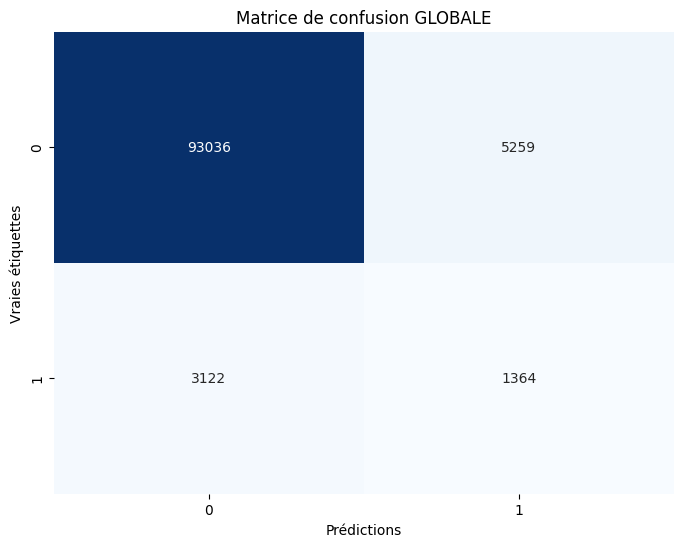

In [74]:
cm = confusion_matrix(df_combined['y_true'], df_combined['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=df_combined['y_true'].unique(), yticklabels=df_combined['y_true'].unique())
plt.title('Matrice de confusion GLOBALE')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

### Filtrer le DataFrame pour ne conserver que les lignes où y_true est égal à y_pred, pour les retards

In [75]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102781 entries, 3718060 to 2412992
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   id                                          102781 non-null  int64  
 1   date_integer                                102781 non-null  int32  
 2   arrival_minutes                             102781 non-null  int32  
 3   connection                                  102781 non-null  int64  
 4   gare actuelle                               102781 non-null  int64  
 5   terminus                                    102781 non-null  int64  
 6   gare de départ                              102781 non-null  int64  
 7   week-end                                    102781 non-null  int32  
 8   jour de la semaine                          102781 non-null  int32  
 9   carrier_Arriva                              102781 non-null  bool   

In [76]:
df_True = df_combined[(df_combined['y_true'] == 1) & (df_combined['y_true'] == df_combined['y_pred'])]
df_True

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_true,y_pred,probability_retard,probability_ponctuelle,erreur,Certain
3718118,568,20220529,2,169,32,113,3,0,1,False,...,False,False,False,False,1,1,0.72,0.28,0.28,0
3718108,568,20220529,4,169,33,113,3,0,1,False,...,False,False,False,False,1,1,0.71,0.29,0.29,0
3718105,568,20220529,7,169,34,113,3,0,1,False,...,False,False,False,False,1,1,0.68,0.32,0.32,0
3718102,568,20220529,10,169,35,113,3,0,1,False,...,False,False,False,False,1,1,0.69,0.31,0.31,0
3718099,568,20220529,12,169,36,113,3,0,1,False,...,False,False,False,False,1,1,0.63,0.37,0.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256633,3149,20220524,730,771,49,195,62,0,2,False,...,False,False,False,False,1,1,0.58,0.42,0.42,0
2186262,3356,20220524,382,827,2,1,310,0,2,False,...,False,False,False,False,1,1,0.52,0.48,0.48,0
2187823,3356,20220524,389,827,1,1,310,0,2,False,...,False,False,False,False,1,1,0.59,0.41,0.41,0
2342048,4200,20220524,986,983,29,23,22,0,2,False,...,False,False,True,False,1,1,0.53,0.47,0.47,0


# 5. 2E modèle basé sur les erreurs

In [77]:
df_combined.to_csv("second_step.csv", index=False)

## Interprétation  : Dans quels domaines on est bon

In [78]:
df_True.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1364 entries, 3718118 to 2345839
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          1364 non-null   int64  
 1   date_integer                                1364 non-null   int32  
 2   arrival_minutes                             1364 non-null   int32  
 3   connection                                  1364 non-null   int64  
 4   gare actuelle                               1364 non-null   int64  
 5   terminus                                    1364 non-null   int64  
 6   gare de départ                              1364 non-null   int64  
 7   week-end                                    1364 non-null   int32  
 8   jour de la semaine                          1364 non-null   int32  
 9   carrier_Arriva                              1364 non-null   bool   
 10  carrier_

### Répartition des bons retards prédits selon la compagnie de train

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\inputtransformer2.py:627: UserWarning: `make_tokens_by_line` received a list of lines which do not have lineending markers ('\n', '\r', '\r\n', '\x0b', '\x0c'), behavior will be unspecified
  tokens_by_line = make_tokens_by_line(lines)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12

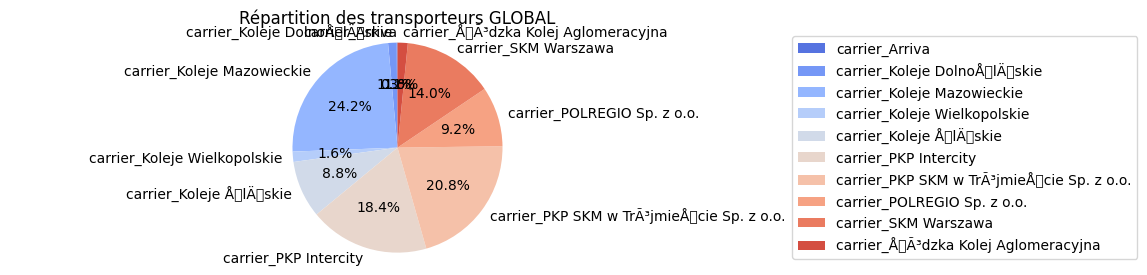

In [79]:
carrier_columns = ['carrier_Arriva', 'carrier_Koleje DolnoÅlÄskie', 'carrier_Koleje Mazowieckie',
                   'carrier_Koleje Wielkopolskie', 'carrier_Koleje ÅlÄskie', 'carrier_PKP Intercity',
                   'carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.', 'carrier_POLREGIO Sp. z o.o.',
                   'carrier_SKM Warszawa', 'carrier_ÅÃ³dzka Kolej Aglomeracyjna']
carrier_counts = df_combined[carrier_columns].sum()
colors = sns.color_palette('coolwarm', n_colors=len(carrier_counts))
plt.figure(figsize=(10, 3))
plt.pie(carrier_counts, labels=carrier_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Répartition des transporteurs GLOBAL')
plt.axis('equal')
plt.legend(carrier_counts.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\inputtransformer2.py:627: UserWarning: `make_tokens_by_line` received a list of lines which do not have lineending markers ('\n', '\r', '\r\n', '\x0b', '\x0c'), behavior will be unspecified
  tokens_by_line = make_tokens_by_line(lines)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12

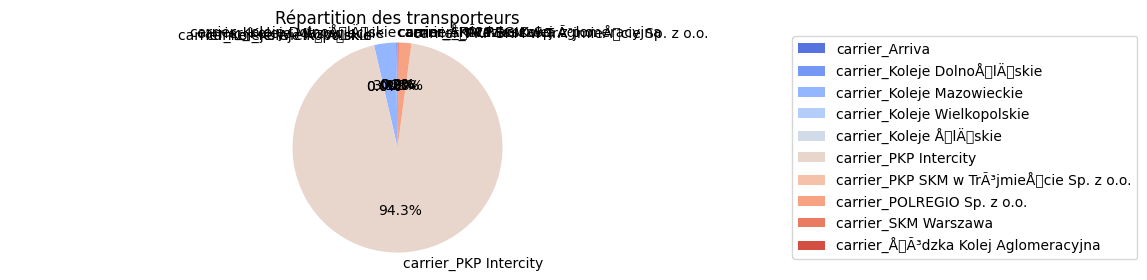

In [80]:
carrier_columns = ['carrier_Arriva', 'carrier_Koleje DolnoÅlÄskie', 'carrier_Koleje Mazowieckie',
                   'carrier_Koleje Wielkopolskie', 'carrier_Koleje ÅlÄskie', 'carrier_PKP Intercity',
                   'carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.', 'carrier_POLREGIO Sp. z o.o.',
                   'carrier_SKM Warszawa', 'carrier_ÅÃ³dzka Kolej Aglomeracyjna']
carrier_counts = df_True[carrier_columns].sum()
colors = sns.color_palette('coolwarm', n_colors=len(carrier_counts))
plt.figure(figsize=(10, 3))
plt.pie(carrier_counts, labels=carrier_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Répartition des transporteurs')
plt.axis('equal')
plt.legend(carrier_counts.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\inputtransformer2.py:627: UserWarning: `make_tokens_by_line` received a list of lines which do not have lineending markers ('\n', '\r', '\r\n', '\x0b', '\x0c'), behavior will be unspecified
  tokens_by_line = make_tokens_by_line(lines)
C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\1377131144.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(12, 6))
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


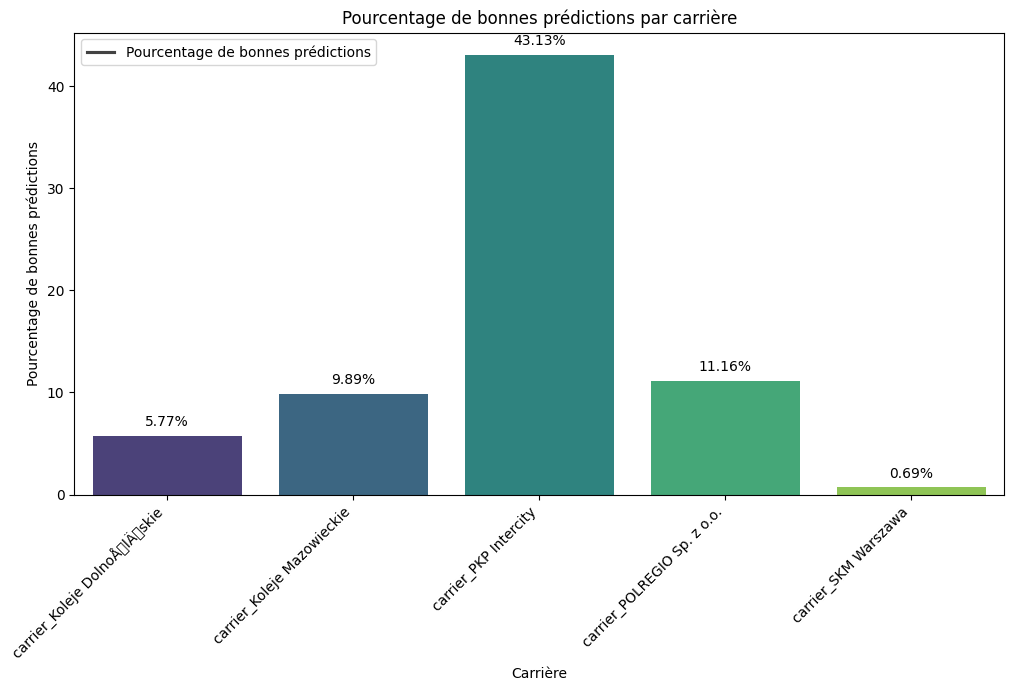

In [81]:
carriers = ['carrier_Koleje DolnoÅlÄskie', 'carrier_Koleje Mazowieckie', 'carrier_PKP Intercity', 'carrier_POLREGIO Sp. z o.o.','carrier_SKM Warszawa']

df_results = pd.DataFrame(index=carriers, columns=['Correct', 'Incorrect', 'Total'])
df_combined2 = df_combined[(df_combined['y_true'] == 1)]
for carrier in carriers:
    correct_predictions = df_combined2[df_combined2[carrier] & (df_combined2['y_true'] == df_combined2['y_pred'])].shape[0]
    incorrect_predictions = df_combined2[df_combined2[carrier] & (df_combined2['y_true'] != df_combined2['y_pred'])].shape[0]
    total_predictions = df_combined2[df_combined2[carrier]].shape[0]
    
    df_results.loc[carrier] = [correct_predictions, incorrect_predictions, total_predictions]

df_results['Percentage'] = (df_results['Correct'] / df_results['Total']) * 100

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=df_results.index, y='Percentage', data=df_results, palette='viridis')
plt.title('Pourcentage de bonnes prédictions par carrière')
plt.xlabel('Carrière')
plt.ylabel('Pourcentage de bonnes prédictions')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Ajouter une légende
plt.legend(['Pourcentage de bonnes prédictions'], loc='upper left')

plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\560783083.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Carrier', y='erreur', data=df_carriers_stacked, palette=palette)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 155 (\x9b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


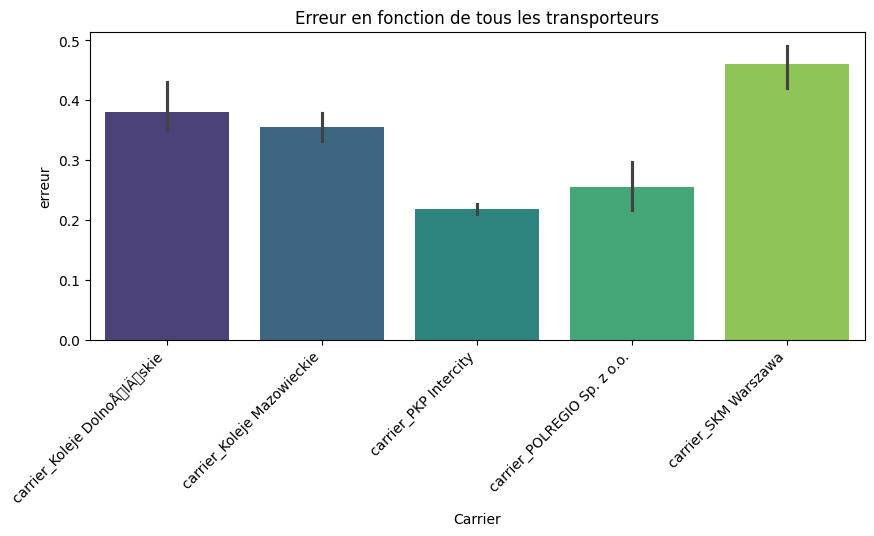

In [82]:
carrier_columns = [col for col in df_True.columns if col.startswith('carrier_')]
df_carriers = df_True[['erreur'] + carrier_columns]

# Faire fondre le DataFrame pour empiler les valeurs des transporteurs
df_carriers_stacked = df_carriers.melt(id_vars='erreur', var_name='Carrier', value_name='IsPresent')
df_carriers_stacked = df_carriers_stacked[df_carriers_stacked['IsPresent'] == True]

# Utiliser une palette de couleurs
palette = sns.color_palette("viridis", n_colors=len(df_carriers_stacked['Carrier'].unique()))

# Tracer le graphique à barres avec la palette
plt.figure(figsize=(10, 4))
sns.barplot(x='Carrier', y='erreur', data=df_carriers_stacked, palette=palette)
plt.title('Erreur en fonction de tous les transporteurs')
plt.xticks(rotation=45, ha='right')
plt.show()

## Répartition des prédictions des retards selon le jour de la semaine

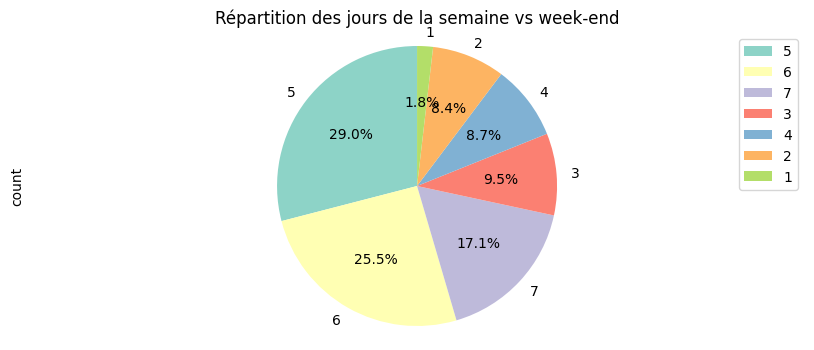

In [83]:
plt.figure(figsize=(10, 4))
colors = sns.color_palette('Set3')
df_True['jour de la semaine'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90,colors = colors)
plt.title('Répartition des jours de la semaine vs week-end')
plt.axis('equal')
plt.legend()
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\265821928.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_errors = df_ridgeline.groupby('jour de la semaine')['erreur'].median().reindex(ordered_days)
C:\Users\aurel\AppData\Local\Programs\Python\Python39\lib\site-packages\joypy\joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)


<Figure size 1200x500 with 0 Axes>

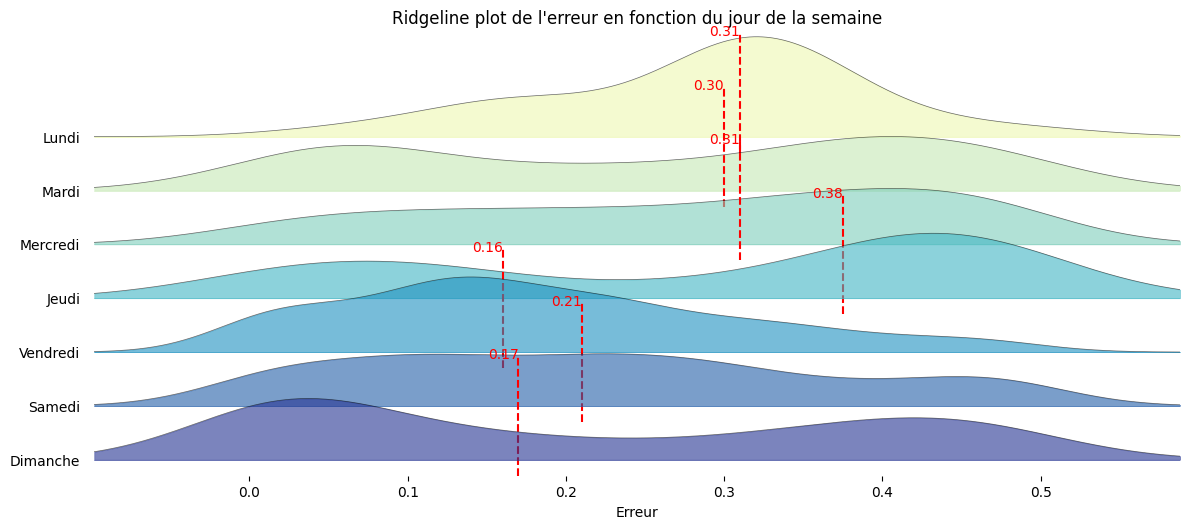

In [109]:
df_ridgeline = df_True[['jour de la semaine', 'erreur']].copy()

# Renommer les jours de la semaine
day_mapping = {1: 'Lundi', 2: 'Mardi', 3: 'Mercredi', 4: 'Jeudi', 5: 'Vendredi', 6: 'Samedi', 7: 'Dimanche'}
df_ridgeline['jour de la semaine'] = df_ridgeline['jour de la semaine'].map(day_mapping)

# Spécifier l'ordre des jours de la semaine
ordered_days = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
df_ridgeline['jour de la semaine'] = pd.Categorical(df_ridgeline['jour de la semaine'], categories=ordered_days, ordered=True)

# Calculer la médiane pour chaque jour
median_errors = df_ridgeline.groupby('jour de la semaine')['erreur'].median().reindex(ordered_days)

# Créer le Ridgeline plot
plt.figure(figsize=(12, 5))
palette = sns.color_palette("YlGnBu", len(ordered_days))
fig, axes = joyplot(
    data=df_ridgeline,
    by='jour de la semaine',
    column='erreur',
    alpha=0.6,
    linewidth=0.5,
    figsize=(12, 5),
    color=palette,
)

# Ajouter les médianes sur le graphique pour chaque courbe individuellement
for ax, day in zip(axes, ordered_days):
    median_value = median_errors[day]
    ax.axvline(median_value, color='r', linestyle='--')
    ax.text(median_value, ax.get_ylim()[1], f'{median_value:.2f}', color='r', ha='right', va='center')

plt.title('Ridgeline plot de l\'erreur en fonction du jour de la semaine')
plt.xlabel('Erreur')
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\141012494.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_error_by_hour = df_time.groupby('hour_interval')['erreur'].mean().reset_index()
C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\141012494.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour_interval', y='erreur', data=mean_error_by_hour, palette=palette)
C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\141012494.py:11: UserWarning: The palette list has more values (30) than needed (24), which may not be intended.
  sns.barplot(x='hour_interval', y='erreur', data=mean_error_by_hour, palette=palette)


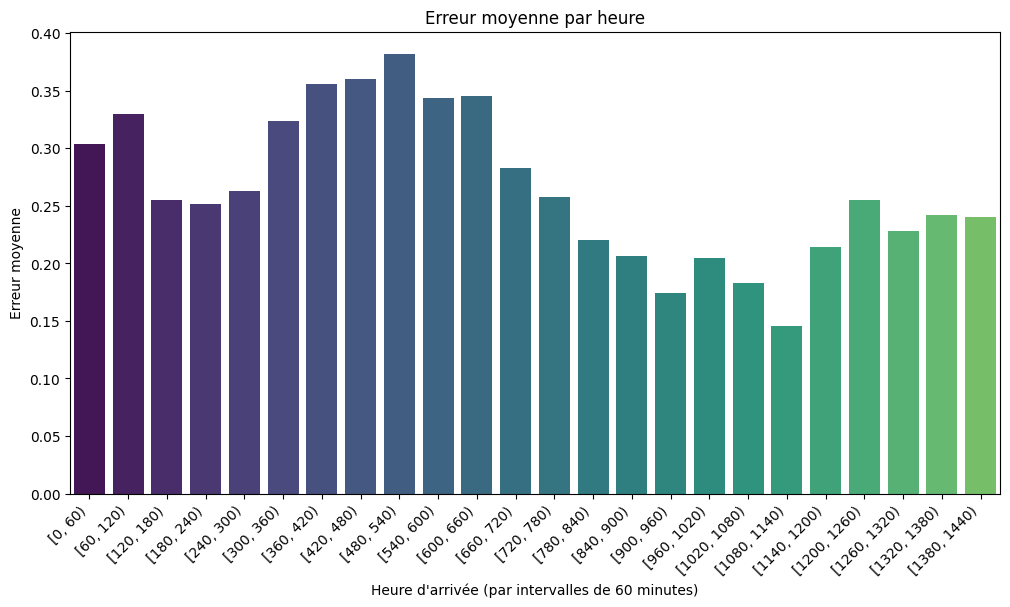

In [110]:
# Diviser les données en intervalles de 60 minutes
df_time = df_True.copy()
df_time['hour_interval'] = pd.cut(df_time['arrival_minutes'], bins=range(0, 1441, 60), right=False)

# Calculer l'erreur moyenne par intervalles d'heures
mean_error_by_hour = df_time.groupby('hour_interval')['erreur'].mean().reset_index()


plt.figure(figsize=(12, 6))
palette = sns.color_palette("viridis", n_colors=len(mean_error_by_station))
sns.barplot(x='hour_interval', y='erreur', data=mean_error_by_hour, palette=palette)
plt.title('Erreur moyenne par heure')
plt.xlabel('Heure d\'arrivée (par intervalles de 60 minutes)')
plt.ylabel('Erreur moyenne')
plt.xticks(rotation=45, ha='right')
plt.show()

### On est "meilleur" sur la PKP intercity

In [86]:
df_for_clustering = df_True.drop(columns=['y_true'])
df_for_clustering = df_for_clustering.dropna()

# Remplacer les valeurs infinies par des valeurs finies
df_for_clustering.replace([np.inf, -np.inf], np.nan, inplace=True)
df_for_clustering = df_for_clustering.dropna()
print(df_for_clustering.dtypes)

id                                              int64
date_integer                                    int32
arrival_minutes                                 int32
connection                                      int64
gare actuelle                                   int64
terminus                                        int64
gare de départ                                  int64
week-end                                        int32
jour de la semaine                              int32
carrier_Arriva                                   bool
carrier_Koleje DolnoÅlÄskie                    bool
carrier_Koleje Mazowieckie                       bool
carrier_Koleje Wielkopolskie                     bool
carrier_Koleje ÅlÄskie                         bool
carrier_PKP Intercity                            bool
carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.       bool
carrier_POLREGIO Sp. z o.o.                      bool
carrier_SKM Warszawa                             bool
carrier_ÅÃ³dzka Kolej Aglom

In [87]:
non_numeric_columns = df_for_clustering.select_dtypes(exclude=['number']).columns

# Afficher les colonnes non numériques
print("Colonnes non numériques : ", non_numeric_columns)
print(df_for_clustering[non_numeric_columns].dtypes)

Colonnes non numériques :  Index(['carrier_Arriva', 'carrier_Koleje DolnoÅlÄskie',
       'carrier_Koleje Mazowieckie', 'carrier_Koleje Wielkopolskie',
       'carrier_Koleje ÅlÄskie', 'carrier_PKP Intercity',
       'carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.',
       'carrier_POLREGIO Sp. z o.o.', 'carrier_SKM Warszawa',
       'carrier_ÅÃ³dzka Kolej Aglomeracyjna'],
      dtype='object')
carrier_Arriva                                bool
carrier_Koleje DolnoÅlÄskie                 bool
carrier_Koleje Mazowieckie                    bool
carrier_Koleje Wielkopolskie                  bool
carrier_Koleje ÅlÄskie                      bool
carrier_PKP Intercity                         bool
carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.    bool
carrier_POLREGIO Sp. z o.o.                   bool
carrier_SKM Warszawa                          bool
carrier_ÅÃ³dzka Kolej Aglomeracyjna          bool
dtype: object


In [88]:
df_for_clustering[non_numeric_columns] = df_for_clustering[non_numeric_columns].astype(int)

In [89]:
print(df_for_clustering.dtypes)

id                                              int64
date_integer                                    int32
arrival_minutes                                 int32
connection                                      int64
gare actuelle                                   int64
terminus                                        int64
gare de départ                                  int64
week-end                                        int32
jour de la semaine                              int32
carrier_Arriva                                  int32
carrier_Koleje DolnoÅlÄskie                   int32
carrier_Koleje Mazowieckie                      int32
carrier_Koleje Wielkopolskie                    int32
carrier_Koleje ÅlÄskie                        int32
carrier_PKP Intercity                           int32
carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.      int32
carrier_POLREGIO Sp. z o.o.                     int32
carrier_SKM Warszawa                            int32
carrier_ÅÃ³dzka Kolej Aglom

In [90]:
df_for_clustering.head(1)

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_pred,probability_retard,probability_ponctuelle,erreur,Certain
3718118,568,20220529,2,169,32,113,3,0,1,0,...,0,0,0,0,0,1,0.72,0.28,0.28,0


In [91]:
from sklearn.preprocessing import LabelEncoder
df_for_clustering2=df_for_clustering.copy()

inverse_gares_dict = {v: k for k, v in gares_dict.items()}
inverse_connection_dict = {v: k for k, v in connections_dict.items()}

df_for_clustering2['gare actuelle'] = df_for_clustering2['gare actuelle'].map(inverse_gares_dict)
df_for_clustering2['gare de départ'] = df_for_clustering2['gare de départ'].map(inverse_gares_dict)
df_for_clustering2['terminus'] = df_for_clustering2['terminus'].map(inverse_gares_dict)
df_for_clustering2['connection'] = df_for_clustering2['connection'].map(inverse_connection_dict)
df_for_clustering2.tail(2)

,id,date_integer,arrival_minutes,connection,gare actuelle,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,...,carrier_PKP Intercity,carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.,carrier_POLREGIO Sp. z o.o.,carrier_SKM Warszawa,carrier_ÅÃ³dzka Kolej Aglomeracyjna,y_pred,probability_retard,probability_ponctuelle,erreur,Certain
2342048,4200,20220524,986,PruszkÃ³w - Otwock,Warszawa Anin,Otwock,PruszkÃ³w,0,2,0,...,0,0,0,1,0,1,0.53,0.47,0.47,0
2345839,4200,20220524,1005,PruszkÃ³w - Otwock,Otwock,Otwock,PruszkÃ³w,0,2,0,...,0,0,0,1,0,1,0.51,0.49,0.49,0


C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\1089159504.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='connection', y='erreur', data=mean_error_by_station, ci=None, palette=palette, order=mean_error_by_station['connection'])
C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\1089159504.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='connection', y='erreur', data=mean_error_by_station, ci=None, palette=palette, order=mean_error_by_station['connection'])


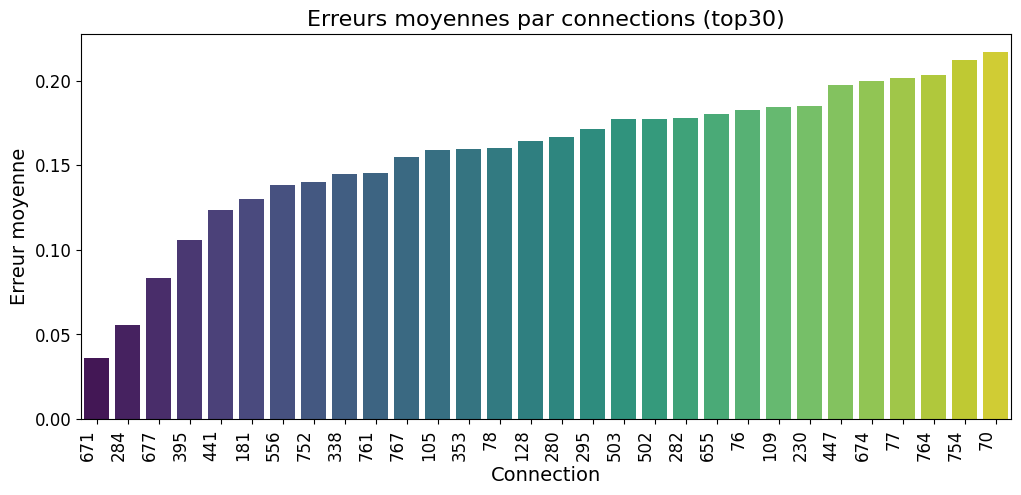

In [92]:
mean_error_by_station = df_True.groupby('connection')['erreur'].mean().reset_index()
mean_error_by_station = mean_error_by_station.sort_values(by='erreur', ascending=True)
mean_error_by_station = mean_error_by_station.head(30)

# Créer un graphique à barres trié avec une palette de couleurs gradient
plt.figure(figsize=(12, 5))
palette = sns.color_palette("viridis", n_colors=len(mean_error_by_station))
sns.barplot(x='connection', y='erreur', data=mean_error_by_station, ci=None, palette=palette, order=mean_error_by_station['connection'])

plt.title('Erreurs moyennes par connections (top30)', fontsize=16)
plt.xlabel('Connection', fontsize=14)
plt.ylabel('Erreur moyenne', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### PARTIE DECISION TREE

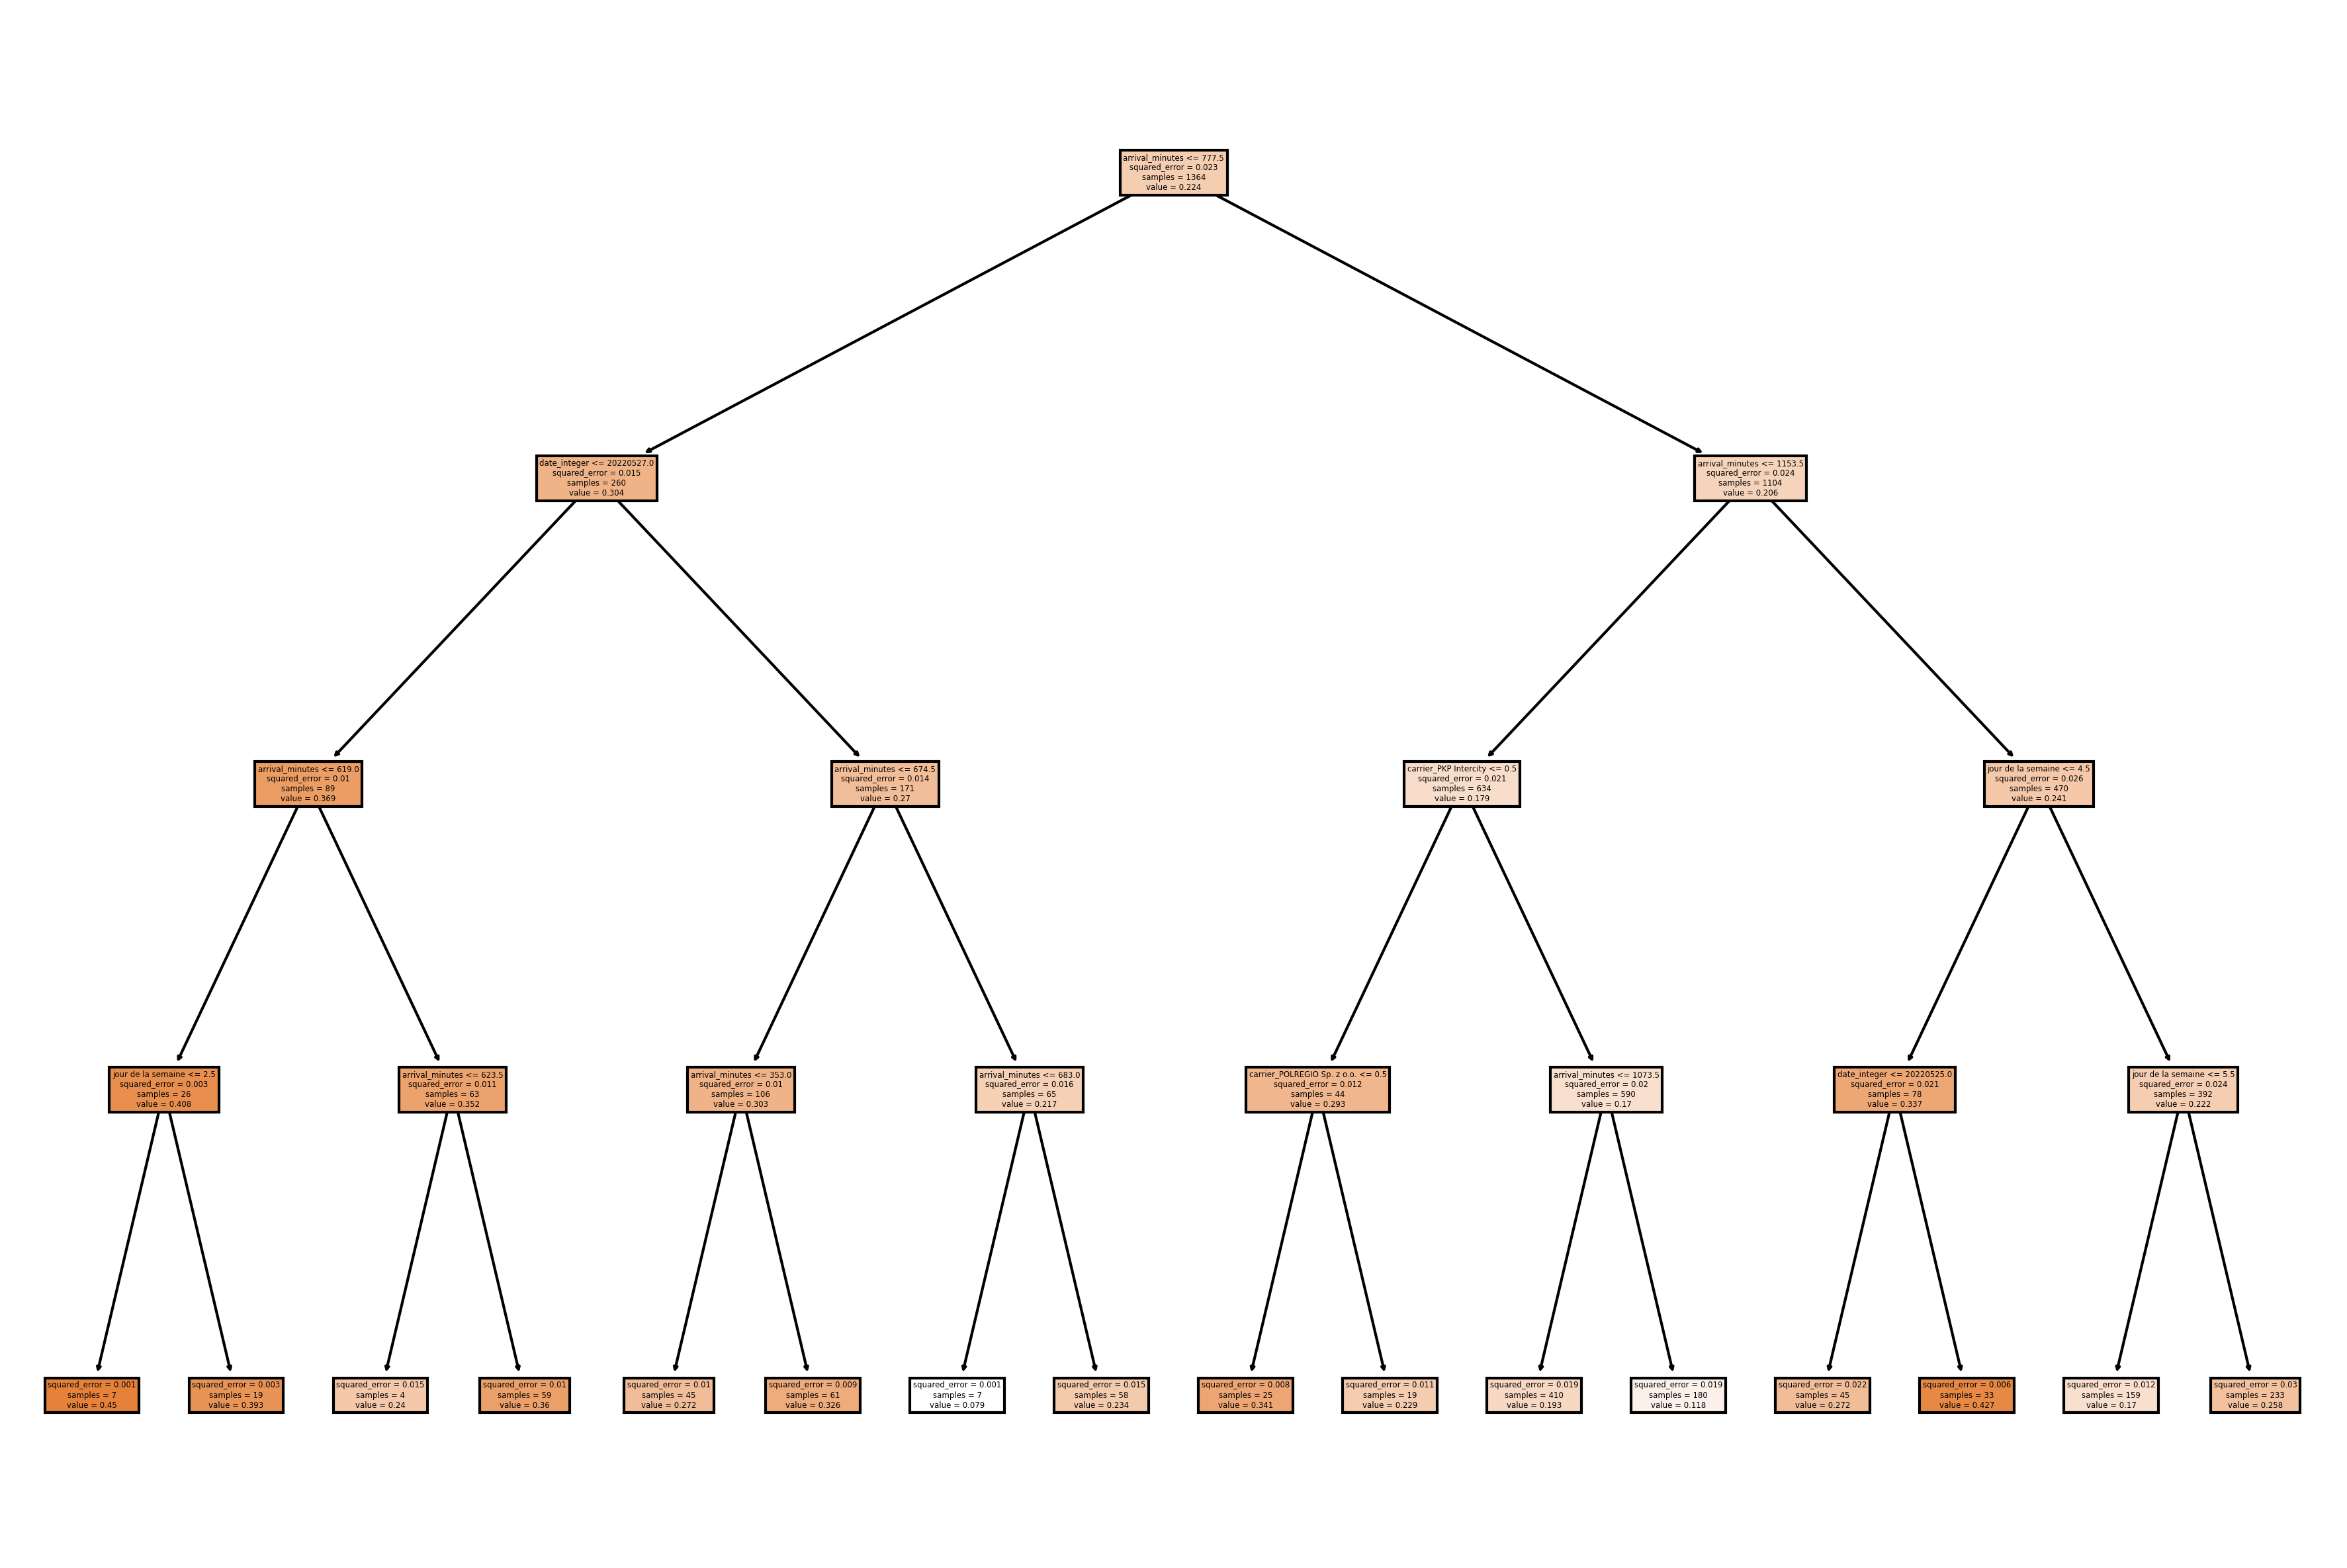

In [96]:
features = df_for_clustering2[['date_integer', 'arrival_minutes', 'week-end', 'jour de la semaine', 'carrier_Arriva',
               'carrier_Koleje DolnoÅlÄskie', 'carrier_Koleje Mazowieckie', 
               'carrier_Koleje Wielkopolskie', 'carrier_Koleje ÅlÄskie', 
               'carrier_PKP Intercity', 'carrier_PKP SKM w TrÃ³jmieÅcie Sp. z o.o.',
               'carrier_POLREGIO Sp. z o.o.', 'carrier_SKM Warszawa', 'carrier_ÅÃ³dzka Kolej Aglomeracyjna']]
target = df_for_clustering2['erreur']

tree_classifier = DecisionTreeRegressor(max_depth=4)

# Entraîner le modèle sur les données
tree_classifier.fit(features, target)

# Tracer l'arbre de décision
plt.figure(figsize=(15, 10),dpi=300)
plot_tree(tree_classifier, filled=True, feature_names=features.columns, class_names=['Not Certain', 'Certain'])
plt.savefig('decision_tree_plot.png')
plt.show()

In [130]:
df_Check = df_combined[(df_combined['y_true'] == 1)& (df_combined['jour de la semaine'] > 4 ) & (df_combined['arrival_minutes'] > 912.5) & (df_combined['carrier_PKP Intercity'] == 1)]
print(df_Check.shape)
print(df_Check[(df_Check['y_pred'] == 1)].shape)

(1106, 25)
(702, 25)


In [127]:
df_Check = df_combined[(df_combined['y_true'] == 1) & (df_combined['arrival_minutes'] > 1153 )& (df_combined['jour de la semaine'] == 5 )]
print(df_Check.shape)
print(df_Check[(df_Check['y_pred'] == 1)].shape)

(329, 25)
(159, 25)


## Conclusion : Branche de droite : On est bon sur PKP intercity, à partir de 15h en fin de semaine (vendredi, samedi, dimanche)

## Pour aller plus loin : Inclusion des gares et connections

In [98]:
columns_to_dummify = ['connection', 'gare actuelle']
df_dummies = pd.get_dummies(df_for_clustering2, columns=columns_to_dummify, drop_first=True)
df_dummies.head(2)

,id,date_integer,arrival_minutes,terminus,gare de départ,week-end,jour de la semaine,carrier_Arriva,carrier_Koleje DolnoÅlÄ skie,carrier_Koleje Mazowieckie,...,gare actuelle_Wejherowo,gare actuelle_WrocÅaw GÅÃ³wny,gare actuelle_WrocÅaw MikoÅajÃ³w,gare actuelle_Zabrze,gare actuelle_Zawiercie,gare actuelle_ZbÄ szynek,gare actuelle_Åowicz GÅÃ³wny,gare actuelle_ÅÃ³dÅº Widzew,gare actuelle_Åwider,gare actuelle_Å»yrardÃ³w
3718118,568,20220529,2,Pilawa,Warszawa Zachodnia,0,1,0,0,1,...,False,False,False,False,False,False,False,False,False,False
3718108,568,20220529,4,Pilawa,Warszawa Zachodnia,0,1,0,0,1,...,False,False,False,False,False,False,False,False,False,False


C:\Users\aurel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\tree\_export.py:664: UserWarning: Glyph 155 (\x9b) missing from current font.
  ann.update_bbox_position_size(renderer)
C:\Users\aurel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\tree\_export.py:664: UserWarning: Glyph 130 (\x82) missing from current font.
  ann.update_bbox_position_size(renderer)
C:\Users\aurel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\tree\_export.py:664: UserWarning: Glyph 154 (\x9a) missing from current font.
  ann.update_bbox_position_size(renderer)
C:\Users\aurel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\tree\_export.py:664: UserWarning: Glyph 132 (\x84) missing from current font.
  ann.update_bbox_position_size(renderer)
C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\2472359163.py:11: UserWarning: Glyph 155 (\x9b) missing from current font.
  plt.savefig('decision_tree_plot2.png')
C:\Users\aurel\AppData\Local\Temp\

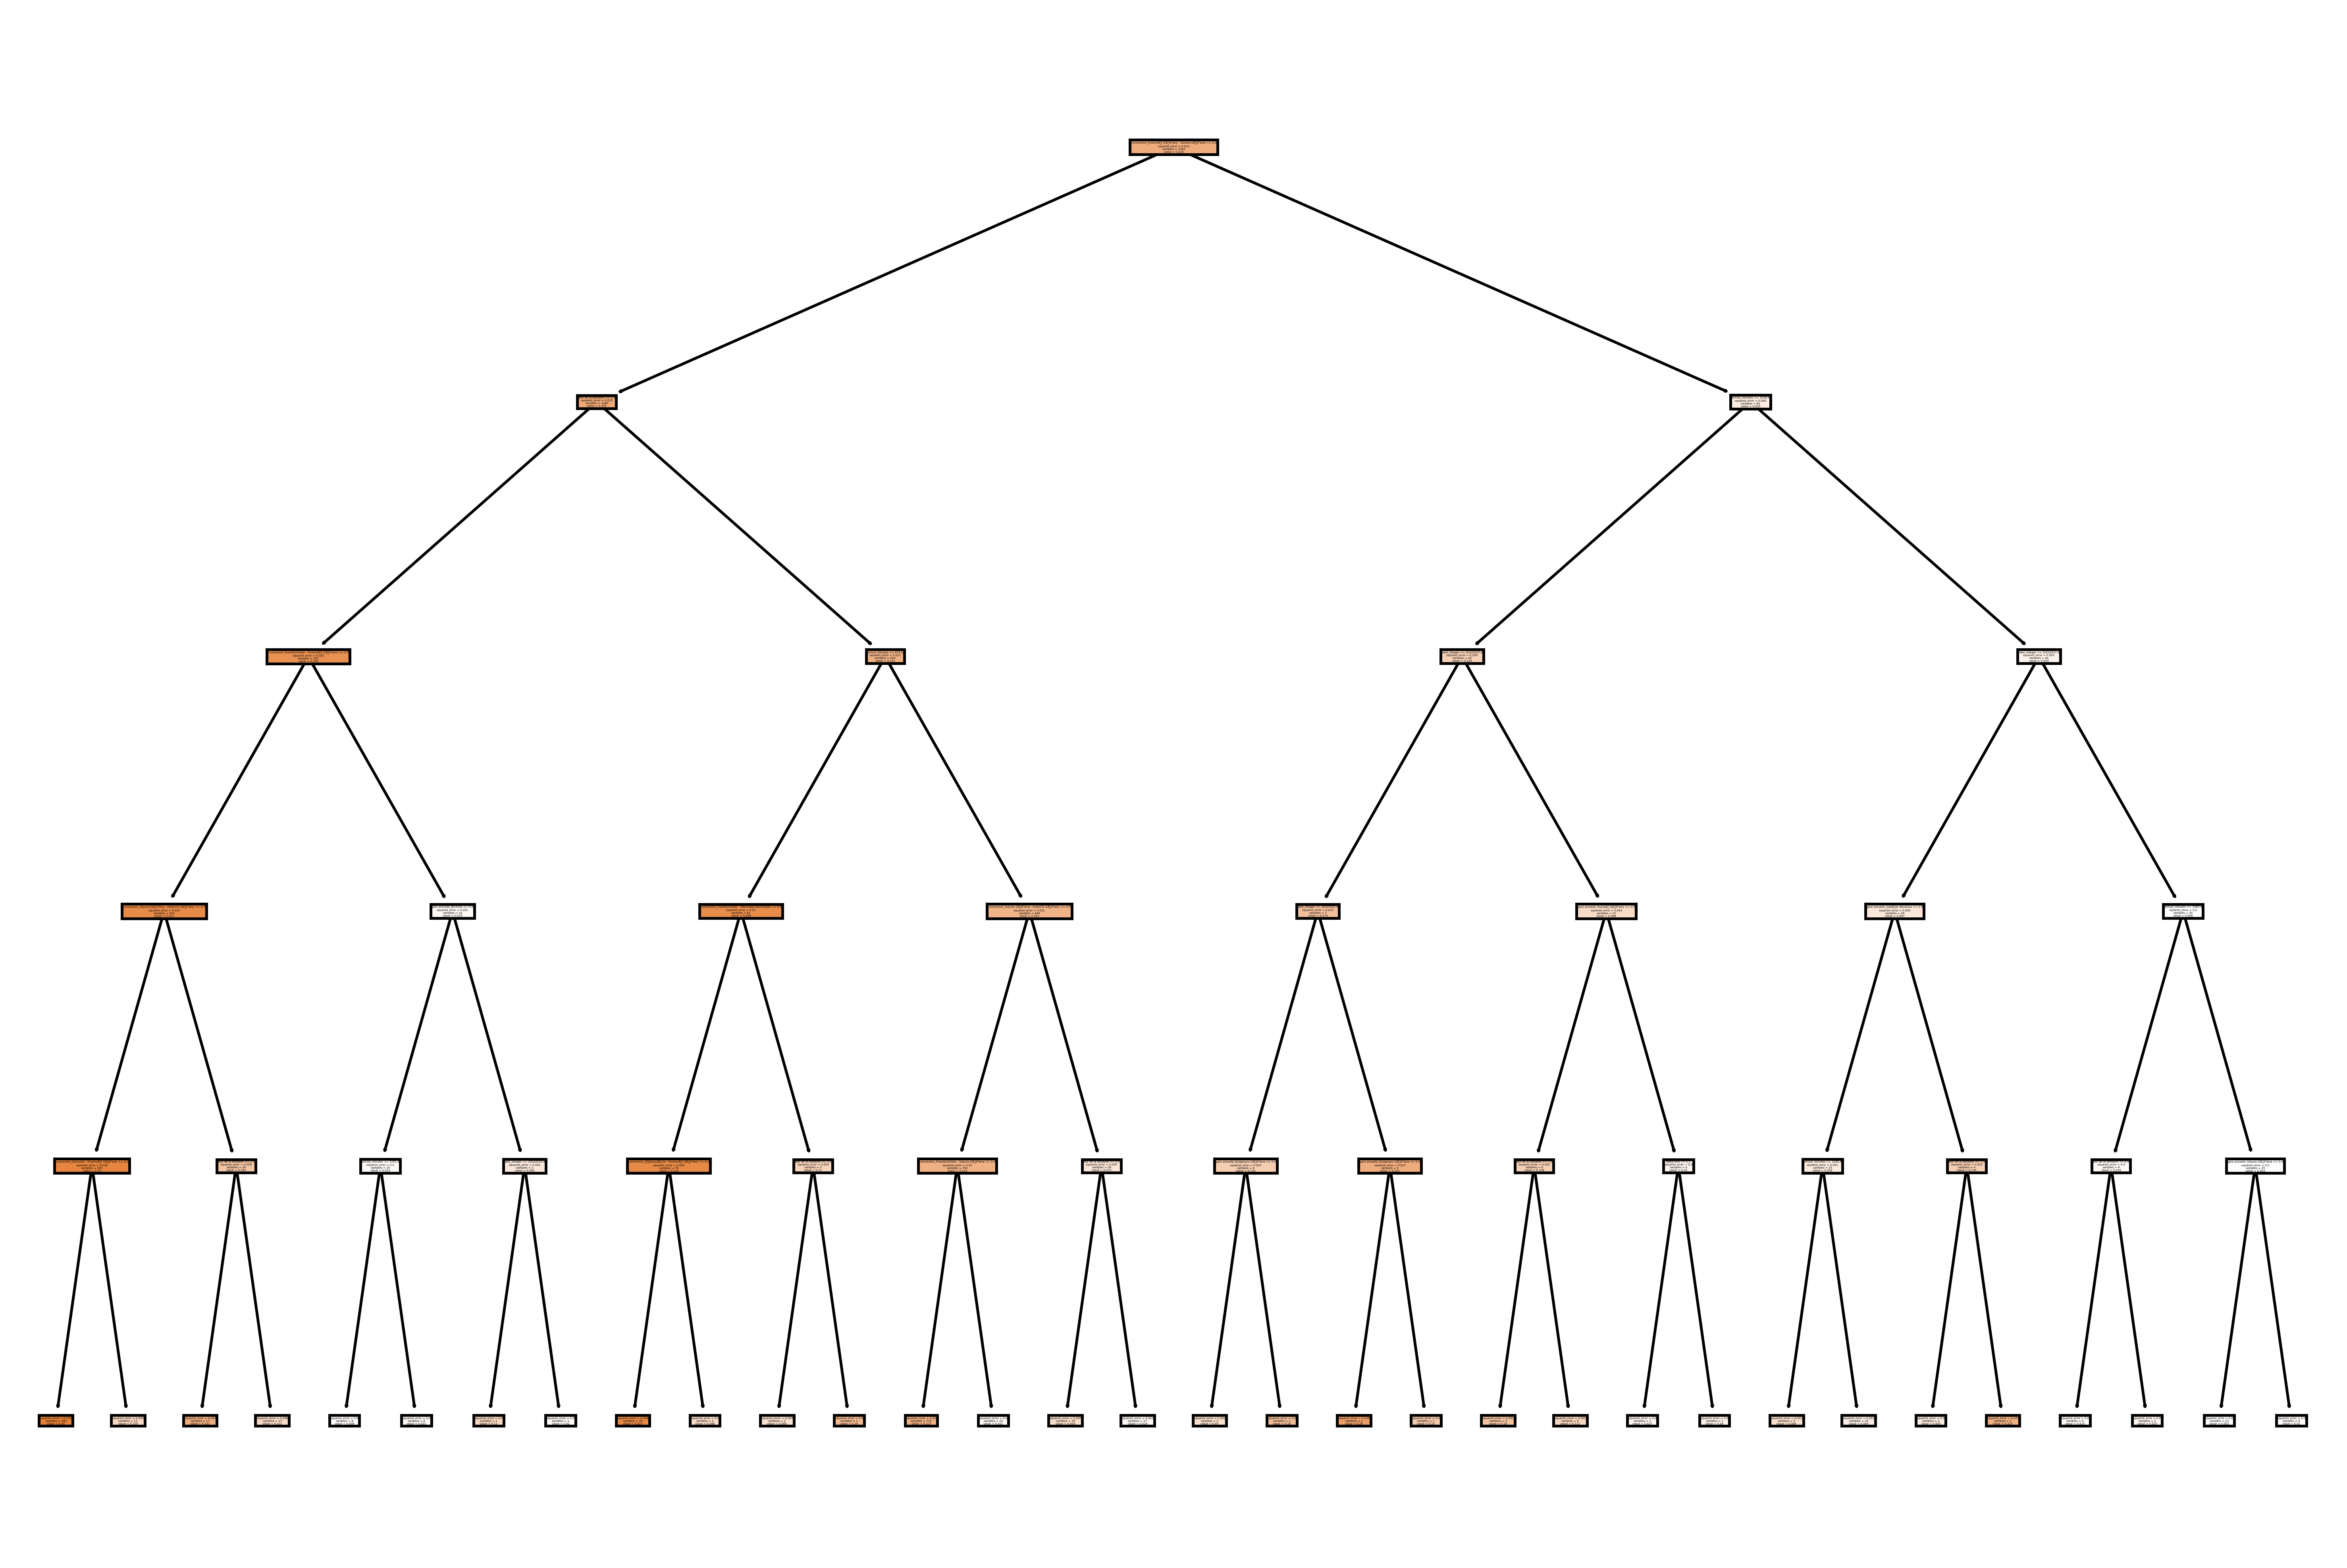

In [99]:
columns_to_exclude = ['id', 'gare de départ', 'terminus','erreur','Certain','probability_ponctuelle','probability_retard','y_pred']
features2 = df_dummies.drop(columns=columns_to_exclude)
target = df_for_clustering2['erreur']

tree_classifier = DecisionTreeRegressor(max_depth=5)
tree_classifier.fit(features2, target)

# Tracer l'arbre de décision
plt.figure(figsize=(15, 10),dpi=500)
plot_tree(tree_classifier, filled=True, feature_names=features2.columns)
plt.savefig('decision_tree_plot2.png')
plt.show()

In [100]:
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes
pd.set_option('display.max_rows',10 )  # Limiter le nombre de lignes affichées
#df_dummies['connection_Frankfurt/Oder - PrzemyÅl GÅÃ³wny'].value_counts()
df_dummies['connection_PrzemyÅl GÅÃ³wny - Gdynia GÅÃ³wna'].value_counts()
#df_dummies.head(1)

connection_PrzemyÅl GÅÃ³wny - Gdynia GÅÃ³wna
False    1280
True       84
Name: count, dtype: int64

In [101]:
df_Check2 = df_combined[(df_combined['connection'] == 284)]
print("connection_PrzemyÅl GÅÃ³wny - Gdynia GÅÃ³wna : ", df_Check2.shape)
print(df_Check2[(df_Check2['y_pred'] == 1)].shape)

connection_PrzemyÅl GÅÃ³wny - Gdynia GÅÃ³wna :  (202, 25)
(97, 25)


In [102]:
df_Check3 = df_combined[(df_combined['connection'] == 282) & (df_combined['jour de la semaine'] >=5 )&(df_combined['jour de la semaine'] <=6)]
print("connection_Krakaw GÅÃ³wny - Gdynia GÅÃ³wna : ", df_Check3.shape)
print(df_Check3[(df_Check3['y_pred'] == 1)].shape)

connection_Krakaw GÅÃ³wny - Gdynia GÅÃ³wna :  (303, 25)
(110, 25)


In [104]:
df_Check2 = df_combined[(df_combined['connection'] == 284)]
print("connection_PrzemyÅl GÅÃ³wny - Gdynia GÅÃ³wna : ", df_Check2.shape)
print(df_Check2[(df_Check2['y_pred'] == 1)&(df_Check2["y_true"]==0)].shape)

connection_PrzemyÅl GÅÃ³wny - Gdynia GÅÃ³wna :  (202, 25)
(13, 25)


## Conclusion sur les gares : 
1 - connection_PrzemyÅl GÅÃ³wny - Gdynia GÅÃ³wna
- 202 trains au total : 97 retards. On en prédit bien 84 : et on est tres confiant (99.5% de confiance d'apres le decision TREE)
- on en a "surprédit" 13 sur les 105 restants (13 faux négatifs).
- (VOIR PPT)

### Plot sur jour de la semaine

## L'erreur en fonction des gares actuelles

C:\Users\aurel\AppData\Local\Temp\ipykernel_17008\3629104704.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gare actuelle', y='erreur', data=df_True, order=sorted_categories, palette=color_palette)


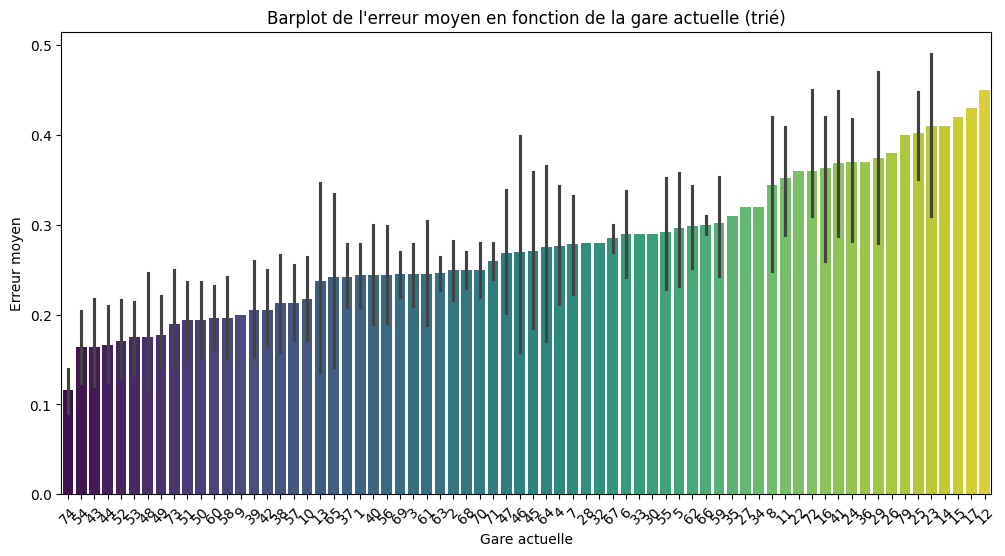

In [111]:
sorted_categories = df_True.groupby('gare actuelle')['erreur'].mean().sort_values().index
color_palette = sns.color_palette("viridis", n_colors=len(sorted_categories))


plt.figure(figsize=(12, 6))
sns.barplot(x='gare actuelle', y='erreur', data=df_True, order=sorted_categories, palette=color_palette)
plt.title('Barplot de l\'erreur moyen en fonction de la gare actuelle (trié)')
plt.xlabel('Gare actuelle')
plt.ylabel('Erreur moyen')
plt.xticks(rotation=45)
plt.show()